## Import Modules

In [1]:
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import collections
import pandas as pd

## Import Dataset (root files)

In [2]:
root_file_750_3, root_file_750_8 = '/workspace/13TeV_750_3.root', '/workspace/13TeV_750_8.root'
root_file_1500_3, root_file_1500_8 = '/workspace/13TeV_1500_3.root', '/workspace/13TeV_1500_8.root'
f750_3, f750_8 = uproot.open(root_file_750_3), uproot.open(root_file_750_8)
f1500_3, f1500_8 = uproot.open(root_file_1500_3), uproot.open(root_file_1500_8)

In [3]:
f750_8['outTree/nominal;1'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
eventNumber          | int64_t                  | AsDtype('>i8')
lumiBlock            | int32_t                  | AsDtype('>i4')
coreFlags            | uint32_t                 | AsDtype('>u4')
bcid                 | int32_t                  | AsDtype('>i4')
mcEventNumber        | int32_t                  | AsDtype('>i4')
mcChannelNumber      | int32_t                  | AsDtype('>i4')
mcEventWeight        | float                    | AsDtype('>f4')
mcEventWeights       | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
timeStamp            | uint32_t                 | AsDtype('>u4')
timeStampNSOffset    | uint32_t                 | AsDtype('>u4')
TileError            | bool                     | AsDtype('bool')
SCTError             | bool              

In [4]:
def DefineBranches(f):
    tree = f['outTree/nominal;1']
    fastjet_pflow = tree.arrays(['na4_pflowjets_raw',
                               'a4_pflowjets_raw_E',
                               'a4_pflowjets_raw_pt',
                               'a4_pflowjets_raw_phi', 
                               'a4_pflowjets_raw_eta'], library='ak')

    fastjet_truth = tree.arrays(['na4_truth',
                                 'a4_truth_E',
                                 'a4_truth_pt',
                                 'a4_truth_phi',
                                 'a4_truth_eta'], library='ak')

    fatjet_lcto = tree.arrays(['na10_lctopojets_raw',
                               'a10_lctopojets_raw_m',
                               'a10_lctopojets_raw_pt',
                               'a10_lctopojets_raw_phi',
                               'a10_lctopojets_raw_eta'], library='ak')

    fatjet_truth = tree.arrays(['na10_truth',
                                'a10_truth_m',
                                'a10_truth_pt',
                                'a10_truth_phi',
                                'a10_truth_eta'], library='ak')

    particle = tree.arrays(['ntruthBSM',
                            'truthBSM_pdgId',
                            'truthBSM_status',
                            'truthBSM_m',
                            'truthBSM_px',
                            'truthBSM_py',
                            'truthBSM_pz',
                            'truthBSM_e',
                            'truthBSM_pt',
                            'truthBSM_eta',
                            'truthBSM_phi'], library='ak')
    
    MET = tree.arrays(['MET_TruthMET_Truth',
                       'MET_TruthMET_TruthPx',
                       'MET_TruthMET_TruthPy'], library='ak')
    return fastjet_pflow, fastjet_truth, fatjet_lcto, fatjet_truth, particle, MET

In [5]:
fastjet_pflow_750_3, fastjet_truth_750_3, fatjet_lcto_750_3, fatjet_truth_750_3, particle_750_3, MET_750_3 = DefineBranches(f750_3)
fastjet_pflow_750_8, fastjet_truth_750_8, fatjet_lcto_750_8, fatjet_truth_750_8, particle_750_8, MET_750_8 = DefineBranches(f750_8)
fastjet_pflow_1500_3, fastjet_truth_1500_3, fatjet_lcto_1500_3, fatjet_truth_1500_3, particle_1500_3, MET_1500_3 = DefineBranches(f1500_3)
fastjet_pflow_1500_8, fastjet_truth_1500_8, fatjet_lcto_1500_8, fatjet_truth_1500_8, particle_1500_8, MET_1500_8 = DefineBranches(f1500_8)

## Sample Truth Particle Information

In [6]:
i = 0
particle = particle_750_3
fd = pd.DataFrame({
      'mass': particle['truthBSM_m'][i],
      'PID': particle['truthBSM_pdgId'][i],
      'e': particle['truthBSM_e'][i],
      'px': particle['truthBSM_px'][i],
      'py': particle['truthBSM_py'][i],
      'pz': particle['truthBSM_pz'][i],
      'pt': particle['truthBSM_pt'][i],
      'eta': particle['truthBSM_eta'][i],
      'phi': particle['truthBSM_phi'][i],
      'status': particle['truthBSM_status'][i]})
fd

,mass,PID,e,px,py,pz,pt,eta,phi,status
0,748.119568,5000001,2699.614502,4.634317,2.871081,-2593.878418,5.451605,-6.858148,0.554654,62
1,10.000000,4900101,1099.522705,-353.831268,91.142532,-1036.989258,365.381348,-1.765967,2.889486,23
2,10.000000,-4900101,1600.091675,358.465607,-88.271454,-1556.889160,369.173981,-2.146093,-0.241444,23
3,0.000000,4900021,58.625713,15.088602,5.362490,-56.396381,16.013189,-1.971712,0.341477,51
4,0.000000,4900021,79.411186,17.399981,-5.731328,-77.269203,18.319592,-2.146237,-0.318195,51
5,0.000000,4900021,36.797810,-11.757918,3.574845,-34.685020,12.289351,-1.760724,2.846436,51
6,10.000000,4900101,1042.723022,-335.557068,85.803619,-983.468567,346.353577,-1.766429,2.891252,71
7,0.000000,4900021,24.324640,-7.772397,2.363098,-22.928013,8.123693,-1.760724,2.846436,71
8,0.000000,4900021,6.856987,2.330769,2.328311,-6.013713,3.294467,-1.362709,0.784871,71
9,0.000000,4900021,9.457777,-3.278449,1.236320,-8.784807,3.503814,-1.649907,2.780977,71


### Proof: there can be events with one hard process dark quark.

In [7]:
# There is one event that has one hard process dark quark.
r = []
for i in tqdm(range(len(particle['truthBSM_status']))):
    r.append(ak.count(ak.where(particle['truthBSM_status'][i]==23)))
    if ak.count(ak.where(particle['truthBSM_status'][i]==23)) != 2:
        print(i)
collections.Counter(r)

100%|██████████| 9960/9960 [00:26<00:00, 373.84it/s]


Counter({2: 9960})

## Cut Flow Table

### Proof: both methods of codings have consistent results.

In [8]:
# Testing 
event_nj, event_pt, event_eta = [], [], []
fastjet_truth = fastjet_truth_750_3
EventSize_fast = len(fastjet_truth['na4_truth'])
fastjet_sort_eta = ak.sort(np.abs(fastjet_truth['a4_truth_eta']), axis=-1, ascending=False)
# Number of Jets
for i in tqdm(range(EventSize_fast)):
    if fastjet_truth['na4_truth'][i] >=2:
        event_nj.append(i)
# PT
for i in tqdm(event_nj):
    if min(fastjet_truth['a4_truth_pt'][i]) > 25:
        event_pt.append(i)
# eta
for i in tqdm(event_pt):
    if max(np.abs(fastjet_truth['a4_truth_eta'][i])) < 2.5:
        event_eta.append(i)
print(EventSize_fast, len(event_nj), len(event_pt), len(event_eta))

EventSize = len(fastjet_truth['na4_truth'])
# Number of Jets >=2 
position_nj = ak.where(fastjet_truth['na4_truth']>=2)[0]
nj_2_pt = fastjet_truth['a4_truth_pt'][position_nj]
# Jets > 25 GeV
position_pt = ak.where(ak.min(nj_2_pt, axis=-1)>25)[0]
position_pt = position_nj[position_pt]
pt_2_eta = np.abs(fastjet_truth['a4_truth_eta'][position_pt])
# |eta| < 2.5
position_eta = ak.where(ak.max(pt_2_eta, axis=-1)<2.5, axis=-1)[0]
position_eta = position_pt[position_eta]
event_eta = fastjet_truth['a4_truth_eta'][position_eta]
print(EventSize, len(nj_2_pt), len(pt_2_eta), len(event_eta))

100%|██████████| 70/70 [00:00<00:00, 1784.90it/s]


9960 9865 70 47
9960 9865 70 47


In [9]:
def CutFlow(NumberJet, JetPt, JetEta):
    EventSize = len(NumberJet)
    # Number of Jets >=2 
    position_nj = ak.where(NumberJet>=2)[0]
    nj_2_pt = JetPt[position_nj]
    # Jets > 25 GeV
    position_pt = ak.where(ak.min(nj_2_pt, axis=-1)>25)[0]
    position_pt = position_nj[position_pt]
    pt_2_eta = np.abs(JetEta[position_pt])
    # |eta| < 2.5
    position_eta = ak.where(ak.max(pt_2_eta, axis=-1)<2.5, axis=-1)[0]
    position_eta = position_pt[position_eta]
    event_eta = JetEta[position_eta]
    return [EventSize, len(nj_2_pt), len(pt_2_eta), len(event_eta)]

In [10]:
# CutFlow Table
name = ['Input Event Size',
        'Number of Jet >= 2',
        'Jet PT > 25 GeV',
        '|eta| < 2.5']

fd = pd.DataFrame({'Selection Cut (750 GeV, 0.3 rinv)': name,
                   'R=0.4 (750 GeV, 0.3 rinv)': CutFlow(fastjet_truth_750_3['na4_truth'], fastjet_truth_750_3['a4_truth_pt'], fastjet_truth_750_3['a4_truth_eta']),
                   'R=1.0 (750 GeV, 0.3 rinv)': CutFlow(fatjet_truth_750_3['na10_truth'], fatjet_truth_750_3['a10_truth_pt'], fatjet_truth_750_3['a10_truth_eta']),
                   'Selection Cut (750 GeV, 0.8 rinv)': name,
                   'R=0.4 (750 GeV, 0.8 rinv)': CutFlow(fastjet_truth_750_8['na4_truth'], fastjet_truth_750_8['a4_truth_pt'], fastjet_truth_750_8['a4_truth_eta']),
                   'R=1.0 (750 GeV, 0.8 rinv)': CutFlow(fatjet_truth_750_8['na10_truth'], fatjet_truth_750_8['a10_truth_pt'], fatjet_truth_750_8['a10_truth_eta']),
                   'Selection Cut (1500 GeV, 0.3 rinv)': name,
                   'R=0.4 (1500 GeV, 0.3 rinv)': CutFlow(fastjet_truth_1500_3['na4_truth'], fastjet_truth_1500_3['a4_truth_pt'], fastjet_truth_1500_3['a4_truth_eta']),
                   'R=1.0 (1500 GeV, 0.3 rinv)': CutFlow(fatjet_truth_1500_3['na10_truth'], fatjet_truth_1500_3['a10_truth_pt'], fatjet_truth_1500_3['a10_truth_eta']),
                   'Selection Cut (1500 GeV, 0.8 rinv)': name,
                   'R=0.4 (1500 GeV, 0.8 rinv)': CutFlow(fastjet_truth_1500_8['na4_truth'], fastjet_truth_1500_8['a4_truth_pt'], fastjet_truth_1500_8['a4_truth_eta']),
                   'R=1.0 (1500 GeV, 0.8 rinv)': CutFlow(fatjet_truth_1500_8['na10_truth'], fatjet_truth_1500_8['a10_truth_pt'], fatjet_truth_1500_8['a10_truth_eta'])
                   })
fd

,"Selection Cut (750 GeV, 0.3 rinv)","R=0.4 (750 GeV, 0.3 rinv)","R=1.0 (750 GeV, 0.3 rinv)","Selection Cut (750 GeV, 0.8 rinv)","R=0.4 (750 GeV, 0.8 rinv)","R=1.0 (750 GeV, 0.8 rinv)","Selection Cut (1500 GeV, 0.3 rinv)","R=0.4 (1500 GeV, 0.3 rinv)","R=1.0 (1500 GeV, 0.3 rinv)","Selection Cut (1500 GeV, 0.8 rinv)","R=0.4 (1500 GeV, 0.8 rinv)","R=1.0 (1500 GeV, 0.8 rinv)"
0,Input Event Size,9960,9960,Input Event Size,9953,9953,Input Event Size,9965,9965,Input Event Size,9960,9960
1,Number of Jet >= 2,9865,6494,Number of Jet >= 2,9187,2743,Number of Jet >= 2,9921,7946,Number of Jet >= 2,9422,4024
2,Jet PT > 25 GeV,70,6483,Jet PT > 25 GeV,108,2735,Jet PT > 25 GeV,72,7935,Jet PT > 25 GeV,120,4015
3,|eta| < 2.5,47,4970,|eta| < 2.5,84,2016,|eta| < 2.5,60,6463,|eta| < 2.5,89,3081


## Kinematic Plots

### Number of Jets

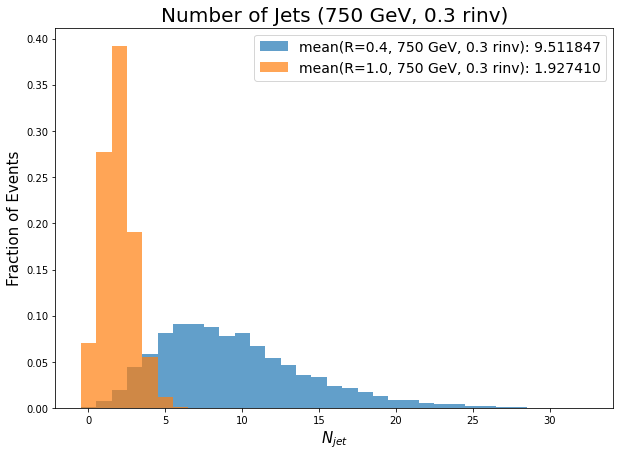

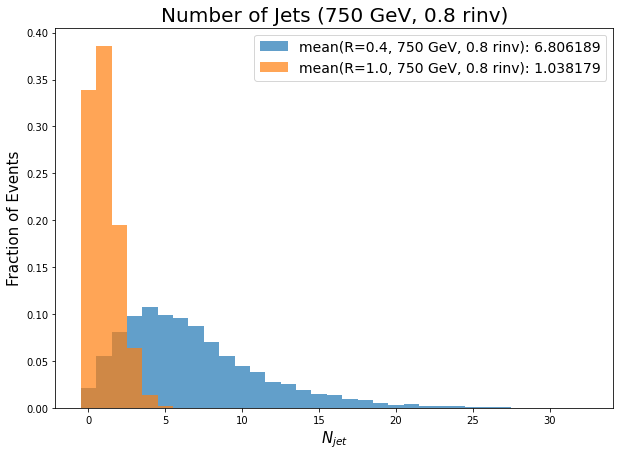

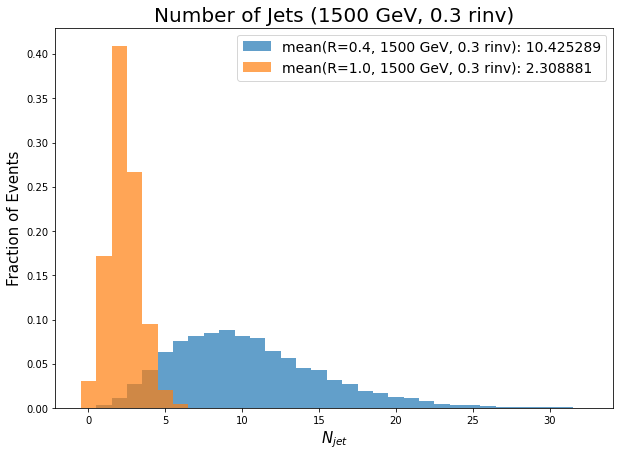

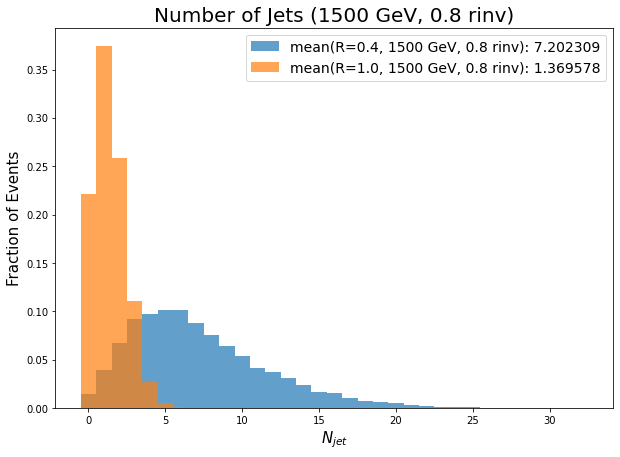

In [11]:
# Number of Jets (750 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
Min, Max = -0.5, 32.5
bins = np.arange(Min, Max+1)
plt.hist(fastjet_truth_750_3['na4_truth'], bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(fastjet_truth_750_3['na4_truth']))
plt.hist(fatjet_truth_750_3['na10_truth'], bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(fatjet_truth_750_3['na10_truth']))
plt.xlabel(r'$N_{jet}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Number of Jets (750 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Number of Jets (750 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(fastjet_truth_750_8['na4_truth'], bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %ak.mean(fastjet_truth_750_8['na4_truth']))
plt.hist(fatjet_truth_750_8['na10_truth'], bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %ak.mean(fatjet_truth_750_8['na10_truth']))
plt.xlabel(r'$N_{jet}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Number of Jets (750 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Number of Jets (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(fastjet_truth_1500_3['na4_truth'], bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(fastjet_truth_1500_3['na4_truth']))
plt.hist(fatjet_truth_1500_3['na10_truth'], bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(fatjet_truth_1500_3['na10_truth']))
plt.xlabel(r'$N_{jet}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Number of Jets (1500 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Number of Jets (1500 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(fastjet_truth_1500_8['na4_truth'], bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(fastjet_truth_1500_8['na4_truth']))
plt.hist(fatjet_truth_1500_8['na10_truth'], bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(fatjet_truth_1500_8['na10_truth']))
plt.xlabel(r'$N_{jet}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Number of Jets (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5
 27.5 28.5 29.5 30.5]


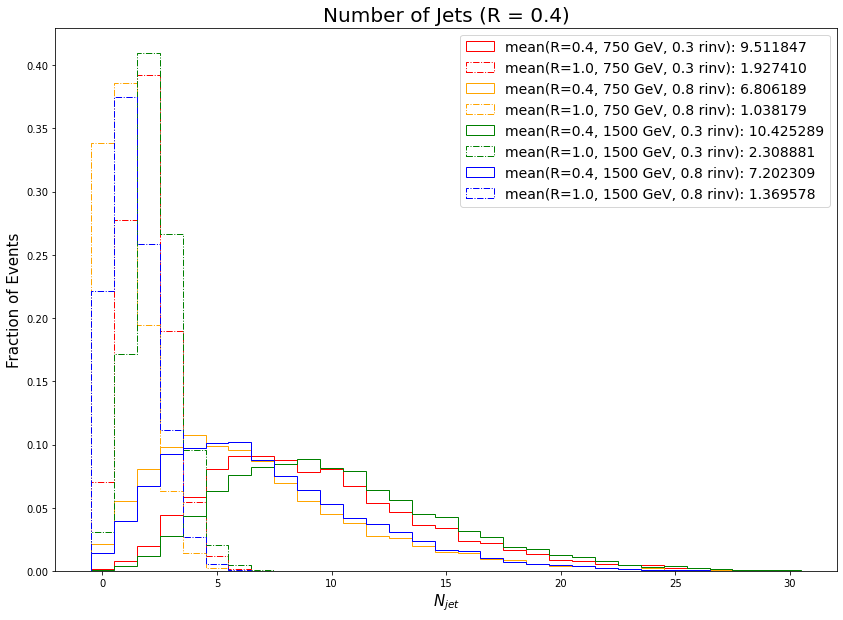

In [12]:
# Number of Jets (Combine four plots)
plt.figure(figsize=(14,10)) 
Min, Max = -0.5, 30.5
bins = np.arange(Min, Max+1)
print(bins)
plt.hist(fastjet_truth_750_3['na4_truth'], bins=bins, histtype='step', color='red', density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(fastjet_truth_750_3['na4_truth']))
plt.hist(fatjet_truth_750_3['na10_truth'], bins=bins, histtype='step', color='red', linestyle='-.', density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(fatjet_truth_750_3['na10_truth']))

plt.hist(fastjet_truth_750_8['na4_truth'], bins=bins, histtype='step', color='orange', density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %ak.mean(fastjet_truth_750_8['na4_truth']))
plt.hist(fatjet_truth_750_8['na10_truth'], bins=bins, histtype='step', color='orange', linestyle='-.', density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %ak.mean(fatjet_truth_750_8['na10_truth']))

plt.hist(fastjet_truth_1500_3['na4_truth'], bins=bins, histtype='step', color='green', density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(fastjet_truth_1500_3['na4_truth']))
plt.hist(fatjet_truth_1500_3['na10_truth'], bins=bins, histtype='step', color='green', linestyle='-.', density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(fatjet_truth_1500_3['na10_truth']))

plt.hist(fastjet_truth_1500_8['na4_truth'], bins=bins, histtype='step', color='blue', density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(fastjet_truth_1500_8['na4_truth']))
plt.hist(fatjet_truth_1500_8['na10_truth'], bins=bins, histtype='step', color='blue', linestyle='-.', density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(fatjet_truth_1500_8['na10_truth']))

plt.xlabel(r'$N_{jet}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Number of Jets (R = 0.4)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

### Proof: TBranches are sorted based on PT value.

In [92]:
fastjet_sort_pt = ak.sort(fastjet_truth_750_3['a4_truth_pt'], axis=-1, ascending=False)
r = ak.flatten(fastjet_sort_pt == fastjet_truth_750_3['a4_truth_pt'])
sum(r), len(r)

(94738, 94738)

In [93]:
ak.mask(fastjet_sort_pt, ak.num(fastjet_sort_pt)>1)[:, 1] # select the second value of each list

<Array [19.1, 25.3, 49.2, ... 49.9, 15.1, 15.5] type='9960 * ?float32'>

In [94]:
ak.firsts(fastjet_sort_pt, highlevel=[-1]) # select the first value of each list

<Array [27.5, 42.6, 264, ... 107, 37.9, 124] type='9960 * ?float32'>

In [46]:
fastjet_truth = ak.where(ak.num(fastjet_truth_750_3['a4_truth_pt'])>=2)
fastjet_truth = fastjet_truth_750_3['a4_truth_pt'][fastjet_truth]
r = []
for i in range(len(fastjet_truth)):
    if len(fastjet_truth[i]) >= 2:
        r.append(1)
    else:
        r.append(0)
collections.Counter(r)

Counter({1: 9865})

## Leading Jet PT and Eta

In [102]:
def LeadingJet(fastjet_truth, fatjet_truth, gev, rinv, color='red', pt=False, eta=False, phi=False, combine=False):
    # Only allowing events with number of jets >= 2
    fastjet_truth_position = ak.where(ak.num(fastjet_truth['a4_truth_pt'])>=2)
    fatjet_truth_position = ak.where(ak.num(fatjet_truth['a10_truth_pt'])>=2)
    if combine:
        if pt:
            fastjet_truth, fatjet_truth = fastjet_truth['a4_truth_pt'][fastjet_truth_position], fatjet_truth['a10_truth_pt'][fatjet_truth_position]
            fast_mean, fat_mean = round(ak.mean(ak.firsts(fastjet_truth)), 5), round(ak.mean(ak.firsts(fatjet_truth)), 5)
            plt.hist(ak.firsts(fastjet_truth), bins=np.linspace(0, 800, 51), histtype='step', color=color, density=True, label=f'mean(R=0.4, {gev}GeV, {rinv} rinv): {fast_mean} GeV')
            plt.hist(ak.firsts(fatjet_truth), bins=np.linspace(0, 800, 51), histtype='step', linestyle='--', color=color, density=True, label=f'mean(R=1.0, {gev}GeV, {rinv} rinv): {fat_mean} GeV')
        elif eta:
            fastjet_truth, fatjet_truth = fastjet_truth['a4_truth_eta'][fastjet_truth_position], fatjet_truth['a10_truth_eta'][fatjet_truth_position]
            fast_mean, fat_mean = round(ak.mean(ak.firsts(fastjet_truth)), 5), round(ak.mean(ak.firsts(fatjet_truth)), 5)
            plt.hist(ak.firsts(fastjet_truth), bins=np.linspace(-5, 5, 51), histtype='step', color=color, density=True, label=f'mean(R=0.4, {gev}GeV, {rinv} rinv): {fast_mean}')
            plt.hist(ak.firsts(fatjet_truth), bins=np.linspace(-5, 5, 51), histtype='step', linestyle='--', color=color, density=True, label=f'mean(R=1.0, {gev}GeV, {rinv} rinv): {fat_mean}')
        elif phi:
            fastjet_truth, fatjet_truth = fastjet_truth['a4_truth_phi'][fastjet_truth_position], fatjet_truth['a10_truth_phi'][fatjet_truth_position]
            fast_mean, fat_mean = round(ak.mean(ak.firsts(fastjet_truth)), 5), round(ak.mean(ak.firsts(fatjet_truth)), 5)
            plt.hist(ak.firsts(fastjet_truth), bins=np.linspace(-5, 5, 51), histtype='step|', color=color, density=True, label=f'mean(R=0.4, {gev}GeV, {rinv} rinv): {fast_mean}')
            plt.hist(ak.firsts(fatjet_truth), bins=np.linspace(-5, 5, 51), histtype='step', linestyle='--', color=color, density=True, label=f'mean(R=1.0, {gev}GeV, {rinv} rinv): {fat_mean}')
        else: 
            print('no result')
    else: 
        if pt:
            fastjet_truth, fatjet_truth = fastjet_truth['a4_truth_pt'][fastjet_truth_position], fatjet_truth['a10_truth_pt'][fatjet_truth_position]
            fast_mean, fat_mean = round(ak.mean(ak.firsts(fastjet_truth)), 5), round(ak.mean(ak.firsts(fatjet_truth)), 5)
            plt.hist(ak.firsts(fastjet_truth), bins=np.linspace(0, 800, 51), alpha=0.7, density=True, label=f'mean(R=0.4, {gev}GeV, {rinv} rinv): {fast_mean} GeV')
            plt.hist(ak.firsts(fatjet_truth), bins=np.linspace(0, 800, 51), alpha=0.7, density=True, label=f'mean(R=1.0, {gev}GeV, {rinv} rinv): {fat_mean} GeV')
        elif eta:
            fastjet_truth, fatjet_truth = fastjet_truth['a4_truth_eta'][fastjet_truth_position], fatjet_truth['a10_truth_eta'][fatjet_truth_position]
            fast_mean, fat_mean = round(ak.mean(ak.firsts(fastjet_truth)), 5), round(ak.mean(ak.firsts(fatjet_truth)), 5)
            plt.hist(ak.firsts(fastjet_truth), bins=np.linspace(-5, 5, 51), alpha=0.7, density=True, label=f'mean(R=0.4, {gev}GeV, {rinv} rinv): {fast_mean}')
            plt.hist(ak.firsts(fatjet_truth), bins=np.linspace(-5, 5, 51), alpha=0.7, density=True, label=f'mean(R=1.0, {gev}GeV, {rinv} rinv): {fat_mean}')
        elif phi:
            fastjet_truth, fatjet_truth = fastjet_truth['a4_truth_phi'][fastjet_truth_position], fatjet_truth['a10_truth_phi'][fatjet_truth_position]
            fast_mean, fat_mean = round(ak.mean(ak.firsts(fastjet_truth)), 5), round(ak.mean(ak.firsts(fatjet_truth)), 5)
            plt.hist(ak.firsts(fastjet_truth), bins=np.linspace(-5, 5, 51), alpha=0.7, density=True, label=f'mean(R=0.4, {gev}GeV, {rinv} rinv): {fast_mean}')
            plt.hist(ak.firsts(fatjet_truth), bins=np.linspace(-5, 5, 51), alpha=0.7, density=True, label=f'mean(R=1.0, {gev}GeV, {rinv} rinv): {fat_mean}')
        else: 
            print('no result')


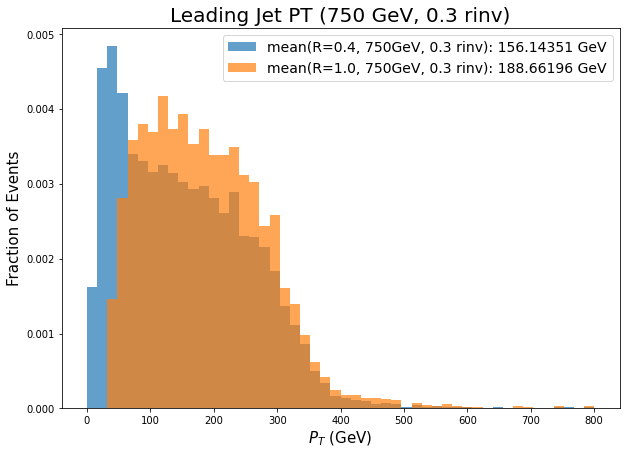

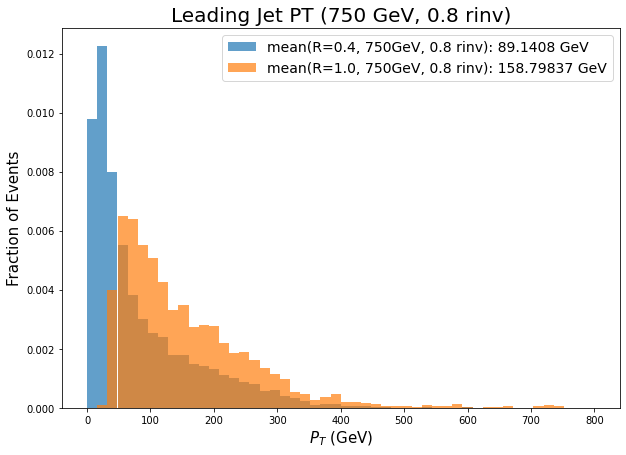

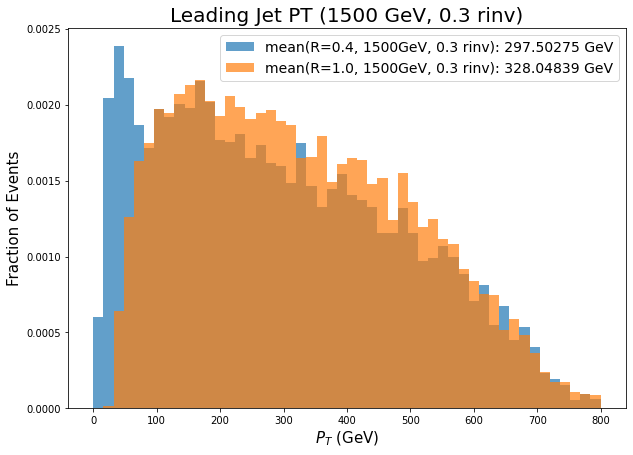

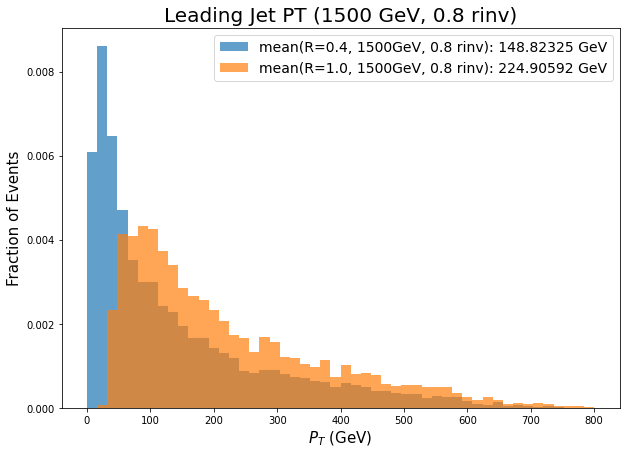

In [98]:
# Leading Jet PT (750 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
LeadingJet(fastjet_truth_750_3, fatjet_truth_750_3, 750, 0.3, pt=True)
plt.xlabel(r'$P_{T}$ (GeV)', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Leading Jet PT (750 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Leading Jet PT (750 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
LeadingJet(fastjet_truth_750_8, fatjet_truth_750_8, 750, 0.8, pt=True)
plt.xlabel(r'$P_{T}$ (GeV)', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Leading Jet PT (750 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Leading Jet PT (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
LeadingJet(fastjet_truth_1500_3, fatjet_truth_1500_3, 1500, 0.3, pt=True)
plt.xlabel(r'$P_{T}$ (GeV)', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Leading Jet PT (1500 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Leading Jet PT (1500 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
LeadingJet(fastjet_truth_1500_8, fatjet_truth_1500_8, 1500, 0.8, pt=True)
plt.xlabel(r'$P_{T}$ (GeV)', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Leading Jet PT (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

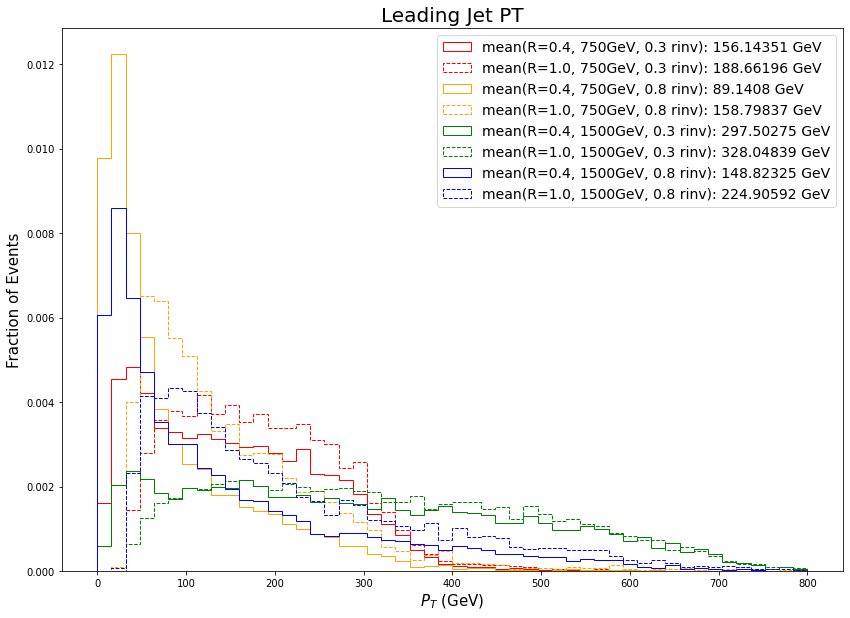

In [99]:
# Leading Jet PT (Combining four plots)
plt.figure(figsize=(14,10)) 
LeadingJet(fastjet_truth_750_3, fatjet_truth_750_3, 750, 0.3, color='red', pt=True, combine=True)
LeadingJet(fastjet_truth_750_8, fatjet_truth_750_8, 750, 0.8, color='orange', pt=True, combine=True)
LeadingJet(fastjet_truth_1500_3, fatjet_truth_1500_3, 1500, 0.3, color='green', pt=True, combine=True)
LeadingJet(fastjet_truth_1500_8, fatjet_truth_1500_8, 1500, 0.8, color='blue', pt=True, combine=True)
plt.xlabel(r'$P_{T}$ (GeV)', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Leading Jet PT', fontsize=20)
plt.legend(fontsize=14)
plt.show()

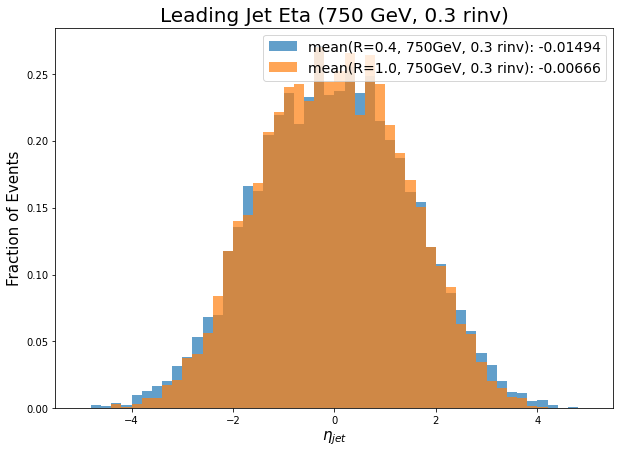

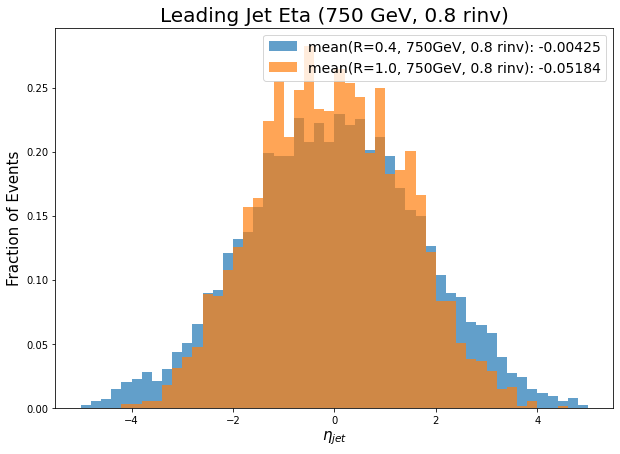

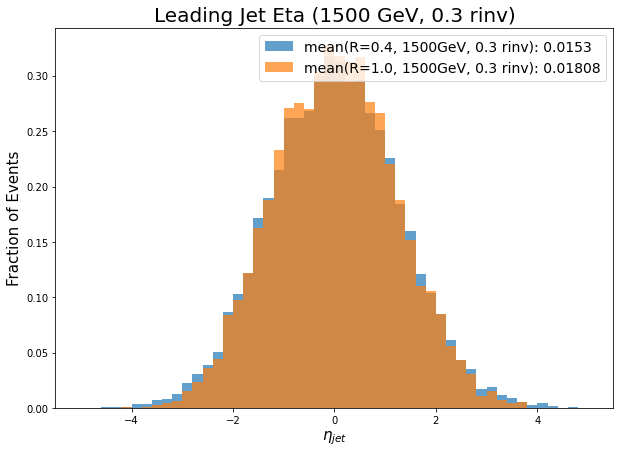

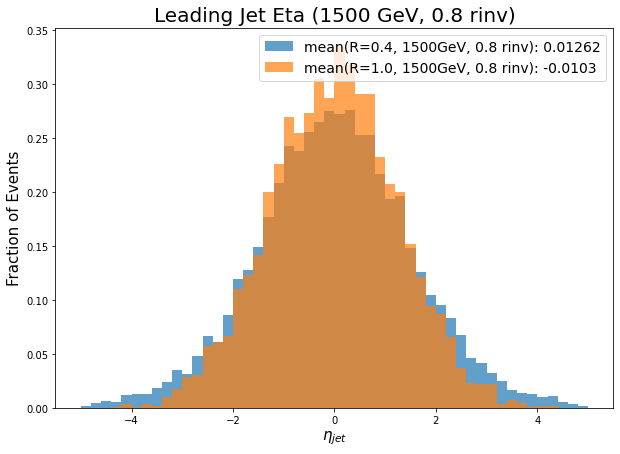

In [100]:
# Leading Jet PT (750 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
LeadingJet(fastjet_truth_750_3, fatjet_truth_750_3, 750, 0.3, eta=True)
plt.xlabel(r'$η_{jet}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Leading Jet Eta (750 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Leading Jet PT (750 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
LeadingJet(fastjet_truth_750_8, fatjet_truth_750_8, 750, 0.8, eta=True)
plt.xlabel(r'$η_{jet}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Leading Jet Eta (750 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Leading Jet PT (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
LeadingJet(fastjet_truth_1500_3, fatjet_truth_1500_3, 1500, 0.3, eta=True)
plt.xlabel(r'$η_{jet}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Leading Jet Eta (1500 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Leading Jet PT (1500 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
LeadingJet(fastjet_truth_1500_8, fatjet_truth_1500_8, 1500, 0.8, eta=True)
plt.xlabel(r'$η_{jet}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Leading Jet Eta (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

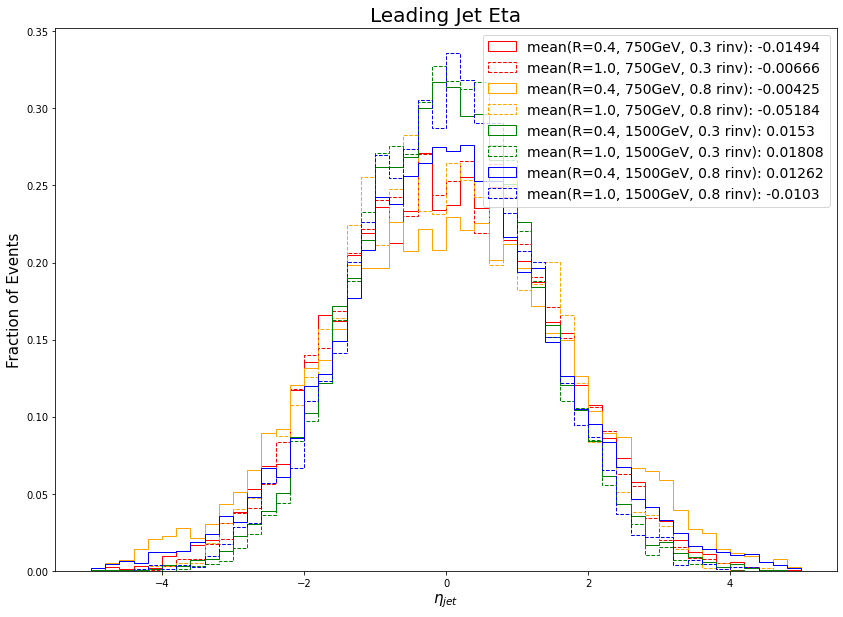

In [103]:
# Leading Jet Eta (combining four plots)
plt.figure(figsize=(14,10)) 
LeadingJet(fastjet_truth_750_3, fatjet_truth_750_3, 750, 0.3, color='red', eta=True, combine=True)
LeadingJet(fastjet_truth_750_8, fatjet_truth_750_8, 750, 0.8, color='orange', eta=True, combine=True)
LeadingJet(fastjet_truth_1500_3, fatjet_truth_1500_3, 1500, 0.3, color='green', eta=True, combine=True)
LeadingJet(fastjet_truth_1500_8, fatjet_truth_1500_8, 1500, 0.8, color='blue', eta=True, combine=True)
plt.xlabel(r'$η_{jet}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Leading Jet Eta', fontsize=20)
plt.legend(fontsize=14)
plt.show()

## Subleading Jet Pt and Eta

In [104]:
def SubleadingJet(fastjet_truth, fatjet_truth, gev, rinv, color='red', pt=False, eta=False, phi=False, combine=False):
    sub_fastjet_eta, sub_fatjet_eta = ak.mask(fastjet_truth['a4_truth_eta'], ak.num(fastjet_truth['a4_truth_eta'])>1)[:, 1], ak.mask(fatjet_truth['a10_truth_eta'], ak.num(fatjet_truth['a10_truth_eta'])>1)[:, 1]
    sub_fastjet_pt, sub_fatjet_pt = ak.mask(fastjet_truth['a4_truth_pt'], ak.num(fastjet_truth['a4_truth_pt'])>1)[:, 1], ak.mask(fatjet_truth['a10_truth_pt'], ak.num(fatjet_truth['a10_truth_pt'])>1)[:, 1]
    sub_fastjet_phi, sub_fatjet_phi = ak.mask(fastjet_truth['a4_truth_phi'], ak.num(fastjet_truth['a4_truth_phi'])>1)[:, 1], ak.mask(fatjet_truth['a10_truth_phi'], ak.num(fatjet_truth['a10_truth_phi'])>1)[:, 1]
    
    if combine:
        if pt:
            fast_mean, fat_mean = round(ak.mean(sub_fastjet_pt), 5), round(ak.mean(sub_fatjet_pt), 5)
            plt.hist(sub_fastjet_pt, bins=np.linspace(0, 600, 51), histtype='step', color=color, density=True, label=f'mean(R=0.4, {gev}GeV, {rinv} rinv): {fast_mean} GeV')
            plt.hist(sub_fatjet_pt, bins=np.linspace(0, 600, 51), histtype='step', linestyle='--', color=color, density=True, label=f'mean(R=1.0, {gev}GeV, {rinv} rinv): {fat_mean} GeV')
        elif eta:
            fast_mean, fat_mean = round(ak.mean(sub_fastjet_eta), 5), round(ak.mean(sub_fatjet_eta), 5)
            plt.hist(sub_fastjet_eta, bins=np.linspace(-5, 5, 71), histtype='step', color=color, density=True, label=f'mean(R=0.4, {gev}GeV, {rinv} rinv): {fast_mean}')
            plt.hist(sub_fatjet_eta, bins=np.linspace(-5, 5, 71), histtype='step', linestyle='--', color=color, density=True, label=f'mean(R=1.0, {gev}GeV, {rinv} rinv): {fat_mean}')
        elif phi:
            fast_mean, fat_mean = round(ak.mean(sub_fastjet_phi), 5), round(ak.mean(sub_fatjet_phi), 5)
            plt.hist(sub_fastjet_phi, bins=np.linspace(-4, 4, 51), histtype='step', color=color, density=True, label=f'mean(R=0.4, {gev}GeV, {rinv} rinv): {fast_mean}')
            plt.hist(sub_fatjet_phi, bins=np.linspace(-5, 5, 51), histtype='step', linestyle='--', color=color, density=True, label=f'mean(R=1.0, {gev}GeV, {rinv} rinv): {fat_mean}')
        else: 
            print('no result')
    else:
        if pt:
            fast_mean, fat_mean = round(ak.mean(sub_fastjet_pt), 5), round(ak.mean(sub_fatjet_pt), 5)
            plt.hist(sub_fastjet_pt, bins=np.linspace(0, 600, 51), alpha=0.7, density=True, label=f'mean(R=0.4, {gev}GeV, {rinv} rinv): {fast_mean} GeV')
            plt.hist(sub_fatjet_pt, bins=np.linspace(0, 600, 51), alpha=0.7, density=True, label=f'mean(R=1.0, {gev}GeV, {rinv} rinv): {fat_mean} GeV')
        elif eta:
            fast_mean, fat_mean = round(ak.mean(sub_fastjet_eta), 5), round(ak.mean(sub_fatjet_eta), 5)
            plt.hist(sub_fastjet_eta, bins=np.linspace(-5, 5, 71), alpha=0.7, density=True, label=f'mean(R=0.4, {gev}GeV, {rinv} rinv): {fast_mean}')
            plt.hist(sub_fatjet_eta, bins=np.linspace(-5, 5, 71), alpha=0.7, density=True, label=f'mean(R=1.0, {gev}GeV, {rinv} rinv): {fat_mean}')
        elif phi:
            fast_mean, fat_mean = round(ak.mean(sub_fastjet_phi), 5), round(ak.mean(sub_fatjet_phi), 5)
            plt.hist(sub_fastjet_phi, bins=np.linspace(-4, 4, 71), alpha=0.7, density=True, label=f'mean(R=0.4, {gev}GeV, {rinv} rinv): {fast_mean}')
            plt.hist(sub_fatjet_phi, bins=np.linspace(-5, 5, 71), alpha=0.7, density=True, label=f'mean(R=1.0, {gev}GeV, {rinv} rinv): {fat_mean}')
        else: 
            print('no result')

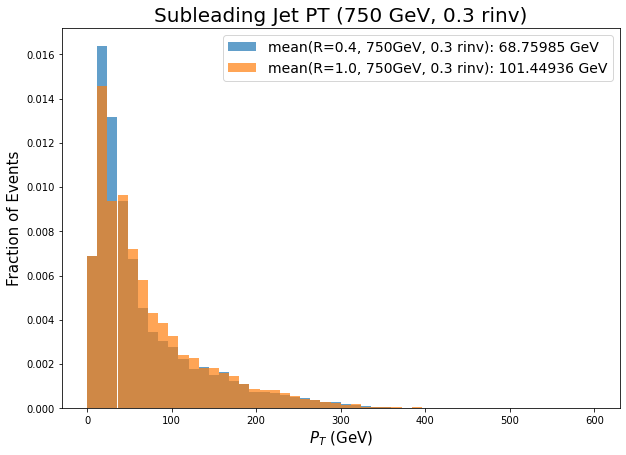

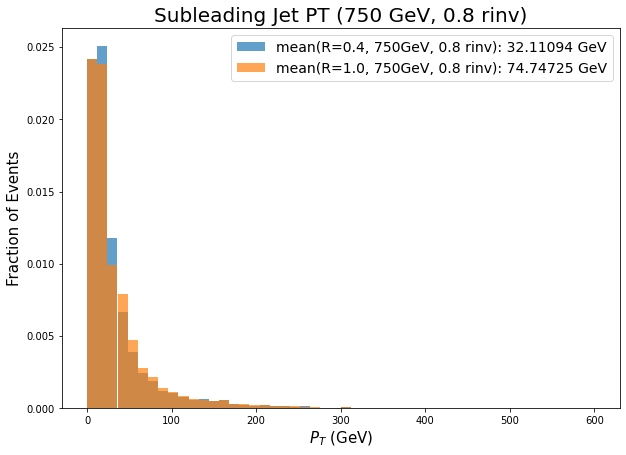

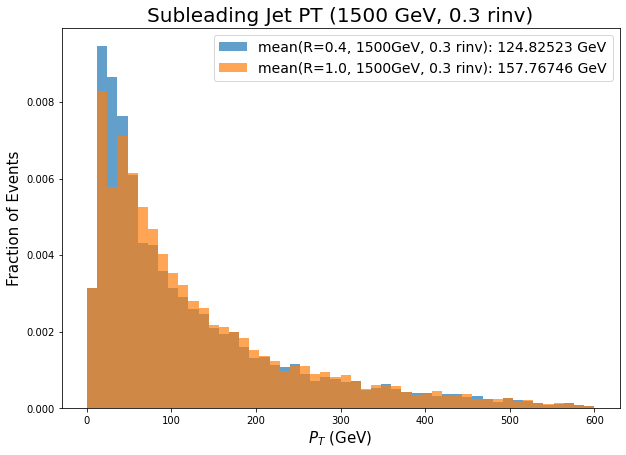

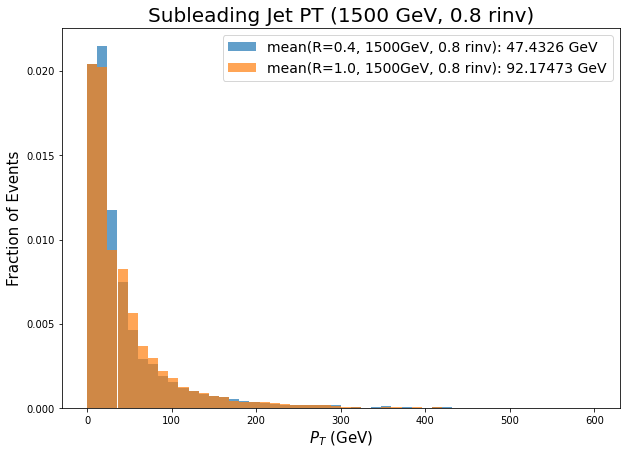

In [105]:
# Subleading Jet PT (750 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
SubleadingJet(fastjet_truth_750_3, fatjet_truth_750_3, 750, 0.3, pt=True)
plt.xlabel(r'$P_{T}$ (GeV)', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Subleading Jet PT (750 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Subleading Jet PT (750 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
SubleadingJet(fastjet_truth_750_8, fatjet_truth_750_8, 750, 0.8, pt=True)
plt.xlabel(r'$P_{T}$ (GeV)', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Subleading Jet PT (750 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Subleading Jet PT (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
SubleadingJet(fastjet_truth_1500_3, fatjet_truth_1500_3, 1500, 0.3, pt=True)
plt.xlabel(r'$P_{T}$ (GeV)', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Subleading Jet PT (1500 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Subleading Jet PT (1500 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
SubleadingJet(fastjet_truth_1500_8, fatjet_truth_1500_8, 1500, 0.8, pt=True)
plt.xlabel(r'$P_{T}$ (GeV)', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Subleading Jet PT (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

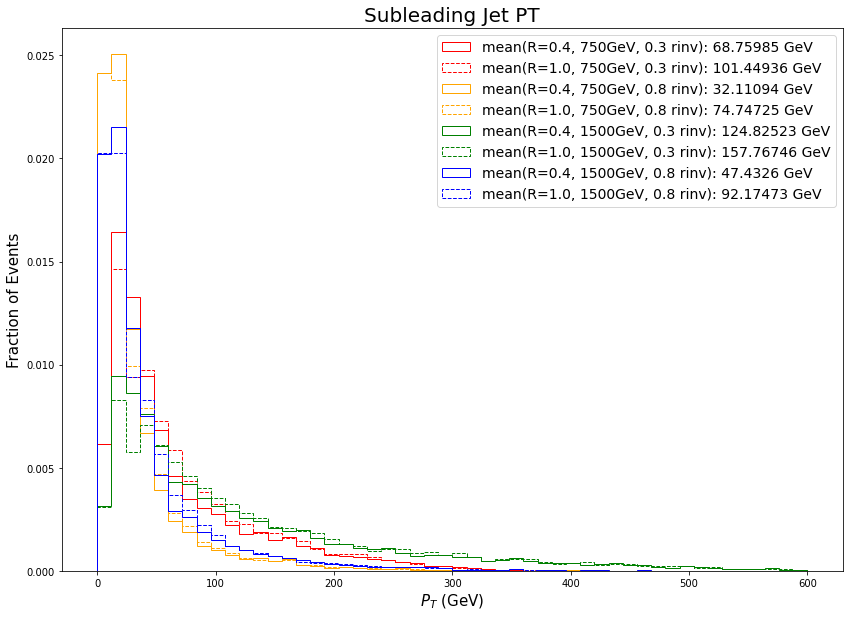

In [106]:
# Subleading Jet PT (combining four plots)
plt.figure(figsize=(14,10)) 
bins = np.linspace(0, 250, 51)
SubleadingJet(fastjet_truth_750_3, fatjet_truth_750_3, 750, 0.3, color='red', pt=True, combine=True)
SubleadingJet(fastjet_truth_750_8, fatjet_truth_750_8, 750, 0.8, color='orange', pt=True, combine=True)
SubleadingJet(fastjet_truth_1500_3, fatjet_truth_1500_3, 1500, 0.3, color='green', pt=True, combine=True)
SubleadingJet(fastjet_truth_1500_8, fatjet_truth_1500_8, 1500, 0.8, color='blue', pt=True, combine=True)
plt.xlabel(r'$P_{T}$ (GeV)', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Subleading Jet PT', fontsize=20)
plt.legend(fontsize=14)
plt.show()

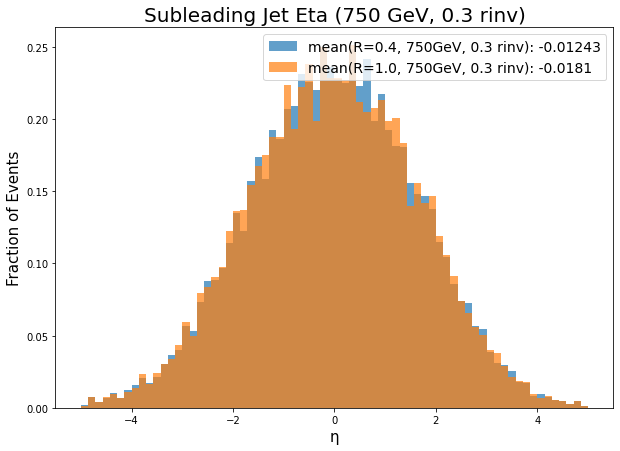

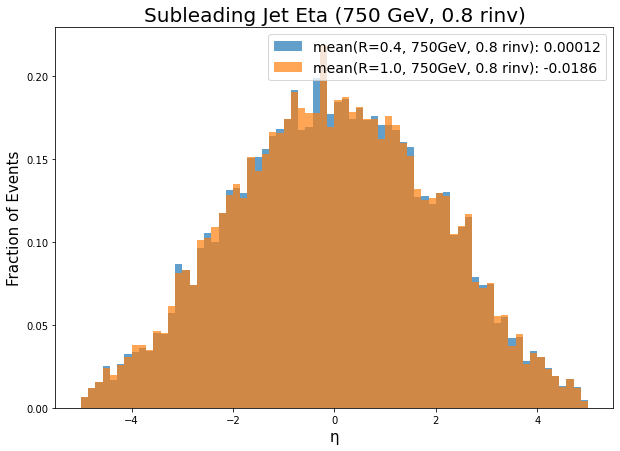

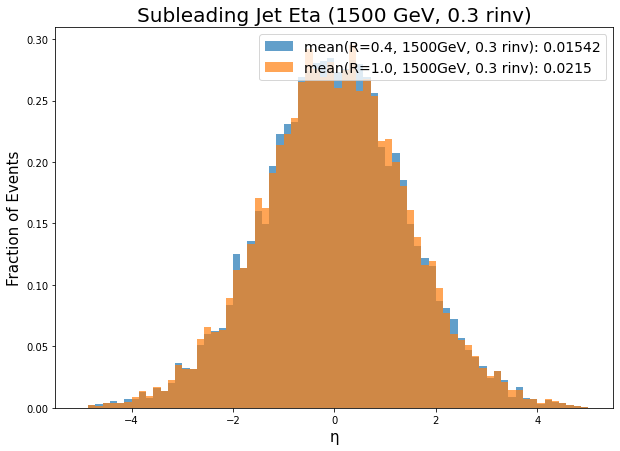

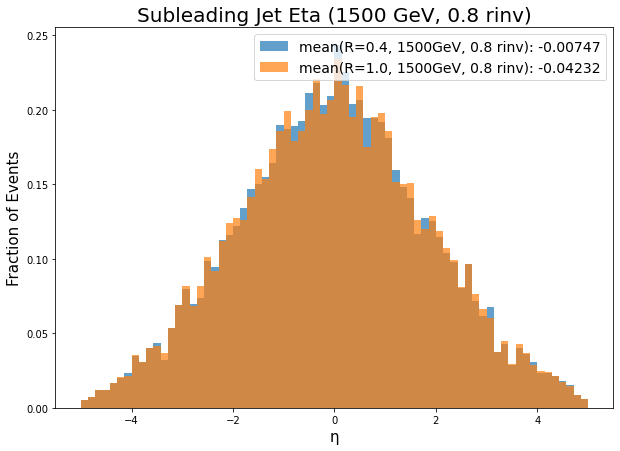

In [107]:
# Subleading Jet Eta (750 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
SubleadingJet(fastjet_truth_750_3, fatjet_truth_750_3, 750, 0.3, eta=True)
plt.xlabel(r'η', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Subleading Jet Eta (750 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Subleading Jet Eta (750 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
SubleadingJet(fastjet_truth_750_8, fatjet_truth_750_8, 750, 0.8, eta=True)
plt.xlabel(r'η', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Subleading Jet Eta (750 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Subleading Jet Eta (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
SubleadingJet(fastjet_truth_1500_3, fatjet_truth_1500_3, 1500, 0.3, eta=True)
plt.xlabel(r'η', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Subleading Jet Eta (1500 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Subleading Jet Eta (1500 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
SubleadingJet(fastjet_truth_1500_8, fatjet_truth_1500_8, 1500, 0.8, eta=True)
plt.xlabel(r'η', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Subleading Jet Eta (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()


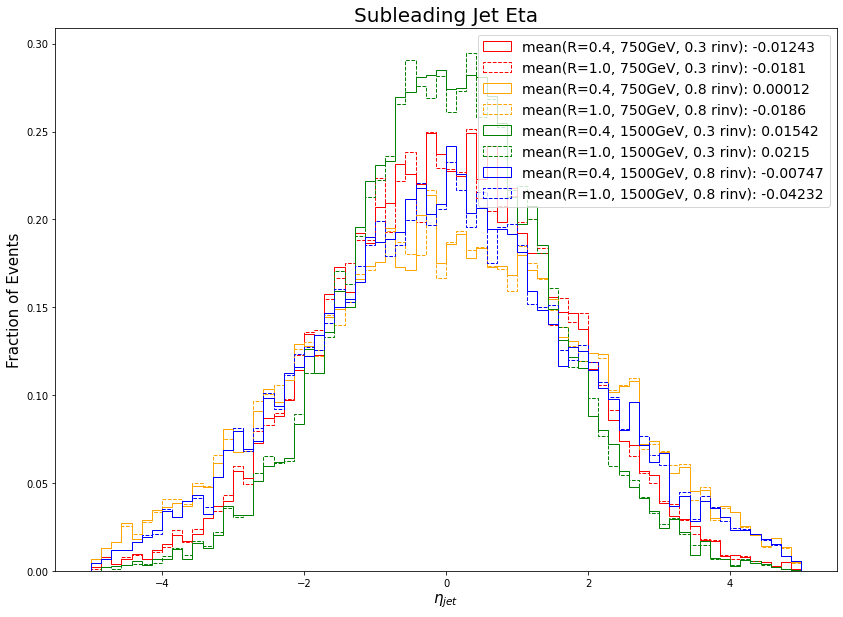

In [108]:
# Subleading Jet Eta (combining four plots)
plt.figure(figsize=(14,10)) 
bins = np.linspace(-6, 6, 51)
SubleadingJet(fastjet_truth_750_3, fatjet_truth_750_3, 750, 0.3, color='red', eta=True, combine=True)
SubleadingJet(fastjet_truth_750_8, fatjet_truth_750_8, 750, 0.8, color='orange', eta=True, combine=True)
SubleadingJet(fastjet_truth_1500_3, fatjet_truth_1500_3, 1500, 0.3, color='green', eta=True, combine=True)
SubleadingJet(fastjet_truth_1500_8, fatjet_truth_1500_8, 1500, 0.8, color='blue', eta=True, combine=True)
plt.xlabel(r'$η_{jet}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Subleading Jet Eta', fontsize=20)
plt.legend(fontsize=14)
plt.show()

In [283]:
# Testing
def FastMT(e1,pt1,eta1,phi1,e2,pt2,eta2,phi2,met,px3,py3):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), pt1*np.sinh(eta1)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), pt2*np.sinh(eta2)
    e3 = met
    
    ejj = e1 + e2
    pxjj, pyjj, pzjj = px1 + px2, py1 + py2, pz1 + pz2
    ptjj = np.sqrt(pxjj**2 + pyjj**2)
    mjj = np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
    ETjj = np.sqrt(mjj**2 + ptjj**2)
    pt3 = np.sqrt(px3**2 + py3**2)
    
    MT = np.sqrt((ETjj+e3)**2 - (ptjj + pt3)**2)
    return MT

def FatMT(m1,pt1,eta1,phi1,m2,pt2,eta2,phi2,met,px3,py3):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), pt1*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2) 
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), pt2*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    e3 = met
    
    ejj = e1 + e2
    pxjj, pyjj, pzjj = px1 + px2, py1 + py2, pz1 + pz2
    ptjj = np.sqrt(pxjj**2 + pyjj**2)
    mjj = np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
    ETjj = np.sqrt(mjj**2 + ptjj**2)
    pt3 = np.sqrt(px3**2 + py3**2)

    MT = np.sqrt((ETjj+e3)**2 - (ptjj + pt3)**2)
    return MT


FastMT(fastjet_truth_750_3['a4_truth_E'][i][0], fastjet_truth_750_3['a4_truth_pt'][i][0], fastjet_truth_750_3['a4_truth_eta'][i][0], fastjet_truth_750_3['a4_truth_phi'][i][0], \
      fastjet_truth_750_3['a4_truth_E'][i][1], fastjet_truth_750_3['a4_truth_pt'][i][1], fastjet_truth_750_3['a4_truth_eta'][i][1], fastjet_truth_750_3['a4_truth_phi'][i][1], \
      MET_750_3['MET_TruthMET_Truth'][i], MET_750_3['MET_TruthMET_TruthPx'][i], MET_750_3['MET_TruthMET_TruthPy'][i])

60.710975822760254

#### Personal Notes:
##### R = 0.4 has energy information, not mass
##### R = 1.0 has mass information, not energy
##### MET has px and py information, not eta or phi

In [28]:
def FastMT(e1,pt1,eta1,phi1,e2,pt2,eta2,phi2,met,px3,py3):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), pt1*np.sinh(eta1)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), pt2*np.sinh(eta2)
    e3 = met
    
    ejj = e1 + e2
    pxjj, pyjj, pzjj = px1 + px2, py1 + py2, pz1 + pz2
    ptjj = np.sqrt(pxjj**2 + pyjj**2)
    mjj = np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
    ETjj = np.sqrt(mjj**2 + ptjj**2)
    pt3 = np.sqrt(px3**2 + py3**2)
    
    MT = np.sqrt((ETjj+e3)**2 - (ptjj + pt3)**2)
    return MT

def FatMT(m1,pt1,eta1,phi1,m2,pt2,eta2,phi2,met,px3,py3):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), pt1*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2) 
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), pt2*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    e3 = met
    
    ejj = e1 + e2
    pxjj, pyjj, pzjj = px1 + px2, py1 + py2, pz1 + pz2
    ptjj = np.sqrt(pxjj**2 + pyjj**2)
    mjj = np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
    ETjj = np.sqrt(mjj**2 + ptjj**2)
    pt3 = np.sqrt(px3**2 + py3**2)
    
    MT = np.sqrt((ETjj+e3)**2 - (ptjj + pt3)**2)
    return MT

def FastM(pt1,eta1,phi1,e1,pt2,eta2,phi2,e2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), pt1*np.sinh(eta1)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), pt2*np.sinh(eta2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)

def FatM(pt1,eta1,phi1,m1,pt2,eta2,phi2,m2):
    px1, py1, pz1 = pt1*np.cos(phi1), pt1*np.sin(phi1), pt1*np.sinh(eta1)
    e1 = np.sqrt(m1**2 + px1**2 + py1**2 + pz1**2)
    px2, py2, pz2 = pt2*np.cos(phi2), pt2*np.sin(phi2), pt2*np.sinh(eta2)
    e2 = np.sqrt(m2**2 + px2**2 + py2**2 + pz2**2)
    
    return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)

def DeltaR_Cal(deltaeta, deltaphi):
    deltaR = np.sqrt(deltaeta**2 + deltaphi**2)
    return np.where(deltaR == np.amin(deltaR))[0][0]

def MatchingJet(jet_truth, particle, MET, fast=False, fat=False):
    if fast:
        position_nj = ak.where(jet_truth['na4_truth']>=2)[0]
        jet_e, jet_pt, jet_eta, jet_phi = jet_truth['a4_truth_E'], jet_truth['a4_truth_pt'], jet_truth['a4_truth_eta'], jet_truth['a4_truth_phi']
    elif fat: 
        position_nj = ak.where(jet_truth['na10_truth']>=2)[0]
        jet_m, jet_pt, jet_eta, jet_phi = jet_truth['a10_truth_m'], jet_truth['a10_truth_pt'], jet_truth['a10_truth_eta'], jet_truth['a10_truth_phi']
        
    MJet1_pt, MJet1_eta, MJet2_pt, MJet2_eta, MJet12_delta_eta, MJet12_delta_phi, MT, Mjj = [], [], [], [], [], [], [], []
    for i in tqdm(position_nj):
        if ak.count(ak.where(particle['truthBSM_status'][i]==23)) == 2:
            particle_eta, particle_phi, jet_truth_eta, jet_truth_phi = particle['truthBSM_eta'][i][ak.where(particle['truthBSM_status'][i]==23)[0]], particle['truthBSM_phi'][i][ak.where(particle['truthBSM_status'][i]==23)[0]], jet_eta[i], jet_phi[i]
            Jet1_eta, Jet2_eta = jet_truth_eta - particle_eta[0], jet_truth_eta - particle_eta[1]
            Jet1_phi, Jet2_phi = np.abs(jet_truth_phi - particle_phi[0]), np.abs(jet_truth_phi - particle_phi[1])
            Jet1_phi = np.array([2*np.pi-i if i > np.pi else i for i in Jet1_phi])
            Jet2_phi = np.array([2*np.pi-i if i > np.pi else i for i in Jet2_phi])
            MatchingJet1_position = DeltaR_Cal(Jet1_eta, Jet1_phi)
            MatchingJet2_position = DeltaR_Cal(Jet2_eta, Jet2_phi)
            MatchingJet1_pt, MatchingJet1_eta, MatchingJet1_phi = jet_pt[i][MatchingJet1_position], jet_eta[i][MatchingJet1_position], jet_phi[i][MatchingJet1_position]
            MatchingJet2_pt, MatchingJet2_eta, MatchingJet2_phi = jet_pt[i][MatchingJet2_position], jet_eta[i][MatchingJet2_position], jet_phi[i][MatchingJet2_position]
            MatchingJet12_delta_eta = np.abs(MatchingJet1_eta - MatchingJet2_eta)
            MatchingJet12_delta_phi = np.abs(MatchingJet1_phi - MatchingJet2_phi)
            if MatchingJet12_delta_phi > np.pi:
                MatchingJet12_delta_phi = 2*np.pi-MatchingJet12_delta_phi
                
            if fast:
                MT.append(FastMT(jet_e[i][MatchingJet1_position], MatchingJet1_pt, MatchingJet1_eta, MatchingJet1_phi, jet_e[i][MatchingJet2_position], \
                                 MatchingJet2_pt, MatchingJet2_eta, MatchingJet2_phi, MET['MET_TruthMET_Truth'][i], MET['MET_TruthMET_TruthPx'][i], MET['MET_TruthMET_TruthPy'][i]))
                Mjj.append(FastM(MatchingJet1_pt, MatchingJet1_eta, MatchingJet1_phi, jet_e[i][MatchingJet1_position], MatchingJet2_pt, \
                                 MatchingJet2_eta, MatchingJet2_phi, jet_e[i][MatchingJet2_position]))
                
            elif fat:
                MT.append(FatMT(jet_m[i][MatchingJet1_position], MatchingJet1_pt, MatchingJet1_eta, MatchingJet1_phi, jet_m[i][MatchingJet2_position], \
                                 MatchingJet2_pt, MatchingJet2_eta, MatchingJet2_phi, MET['MET_TruthMET_Truth'][i], MET['MET_TruthMET_TruthPx'][i], MET['MET_TruthMET_TruthPy'][i]))
                Mjj.append(FatM(MatchingJet1_pt, MatchingJet1_eta, MatchingJet1_phi, jet_m[i][MatchingJet1_position], MatchingJet2_pt, \
                                 MatchingJet2_eta, MatchingJet2_phi, jet_m[i][MatchingJet2_position]))
                
            MJet1_pt.append(MatchingJet1_pt)
            MJet1_eta.append(MatchingJet1_eta)
            MJet2_pt.append(MatchingJet2_pt)
            MJet2_eta.append(MatchingJet2_eta)
            MJet12_delta_eta.append(MatchingJet12_delta_eta)
            MJet12_delta_phi.append(MatchingJet12_delta_phi)
        else:
            continue
    if fast:
        return MJet1_pt, MJet1_eta, MJet2_pt, MJet2_eta, MJet12_delta_eta, MJet12_delta_phi, MT, Mjj
    elif fat:
        return MJet1_pt, MJet1_eta, MJet2_pt, MJet2_eta, MJet12_delta_eta, MJet12_delta_phi, MT, Mjj



In [29]:
FastJet1_pt_750_3, FastJet1_eta_750_3, FastJet2_pt_750_3, FastJet2_eta_750_3, FastJet12_delta_eta_750_3, FastJet12_delta_phi_750_3, FastJet_MT_750_3, FastJet_Mjj_750_3 = MatchingJet(fastjet_truth_750_3, particle_750_3, MET_750_3, fast=True)
FatJet1_pt_750_3, FatJet1_eta_750_3, FatJet2_pt_750_3, FatJet2_eta_750_3, FatJet12_delta_eta_750_3, FatJet12_delta_phi_750_3, FatJet_MT_750_3, FatJet_Mjj_750_3 = MatchingJet(fatjet_truth_750_3, particle_750_3, MET_750_3, fat=True)

100%|██████████| 6494/6494 [01:26<00:00, 75.30it/s]


In [30]:
FastJet1_pt_750_8, FastJet1_eta_750_8, FastJet2_pt_750_8, FastJet2_eta_750_8, FastJet12_delta_eta_750_8, FastJet12_delta_phi_750_8, FastJet_MT_750_8, FastJet_Mjj_750_8 = MatchingJet(fastjet_truth_750_8, particle_750_8, MET_750_8, fast=True)
FatJet1_pt_750_8, FatJet1_eta_750_8, FatJet2_pt_750_8, FatJet2_eta_750_8, FatJet12_delta_eta_750_8, FatJet12_delta_phi_750_8, FatJet_MT_750_8, FatJet_Mjj_750_8 = MatchingJet(fatjet_truth_750_8, particle_750_8, MET_750_8, fat=True)

 66%|██████▋   | 6109/9187 [01:22<00:38, 80.35it/s]<ipython-input-28-15fbb4feed60>:9: RuntimeWarning: invalid value encountered in sqrt
  mjj = np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
<ipython-input-28-15fbb4feed60>:37: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)
 21%|██        | 569/2743 [00:08<00:33, 64.88it/s]<ipython-input-28-15fbb4feed60>:26: RuntimeWarning: invalid value encountered in sqrt
  mjj = np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
<ipython-input-28-15fbb4feed60>:45: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((e1+e2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2)
 72%|███████▏  | 1967/2743 [00:30<00:09, 77.81it/s]<ipython-input-28-15fbb4feed60>:30: RuntimeWarning: invalid value encountered in sqrt
  MT = np.sqrt((ETjj+e3)**2 - (ptjj + pt3)**2)
100%|██████████| 2743/2743 [00:40<00:00, 68.18it/s]


In [60]:
FastJet1_pt_1500_3, FastJet1_eta_1500_3, FastJet2_pt_1500_3, FastJet2_eta_1500_3, FastJet12_delta_eta_1500_3, FastJet12_delta_phi_1500_3, FastJet_MT_1500_3, FastJet_Mjj_1500_3 = MatchingJet(fastjet_truth_1500_3, particle_1500_3, MET_1500_3, fast=True)
FatJet1_pt_1500_3, FatJet1_eta_1500_3, FatJet2_pt_1500_3, FatJet2_eta_1500_3, FatJet12_delta_eta_1500_3, FatJet12_delta_phi_1500_3, FatJet_MT_1500_3, FatJet_Mjj_1500_3 = MatchingJet(fatjet_truth_1500_3, particle_1500_3, MET_1500_3, fat=True)

100%|██████████| 7946/7946 [01:46<00:00, 74.90it/s]


In [61]:
FastJet1_pt_1500_8, FastJet1_eta_1500_8, FastJet2_pt_1500_8, FastJet2_eta_1500_8, FastJet12_delta_eta_1500_8, FastJet12_delta_phi_1500_8, FastJet_MT_1500_8, FastJet_Mjj_1500_8 = MatchingJet(fastjet_truth_1500_8, particle_1500_8, MET_1500_8, fast=True)
FatJet1_pt_1500_8, FatJet1_eta_1500_8, FatJet2_pt_1500_8, FatJet2_eta_1500_8, FatJet12_delta_eta_1500_8, FatJet12_delta_phi_1500_8, FatJet_MT_1500_8, FatJet_Mjj_1500_8 = MatchingJet(fatjet_truth_1500_8, particle_1500_8, MET_1500_8, fat=True)

100%|██████████| 4024/4024 [00:55<00:00, 72.71it/s]


## Matching Jets PT

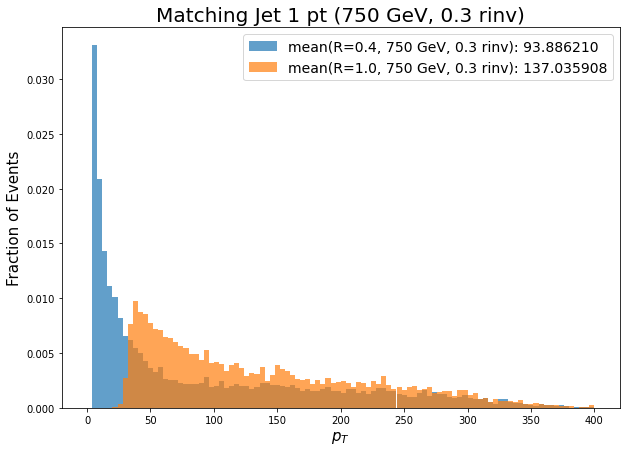

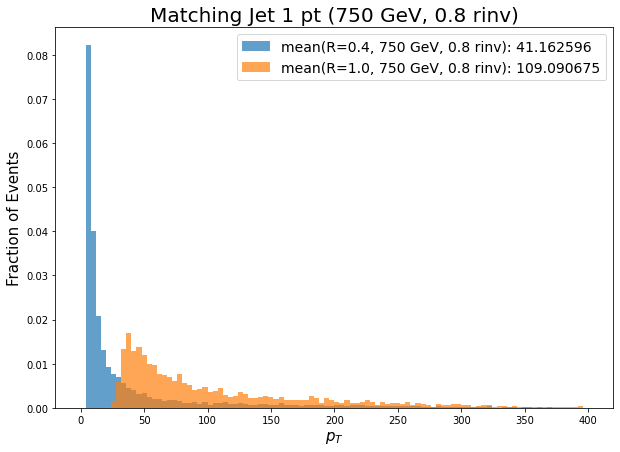

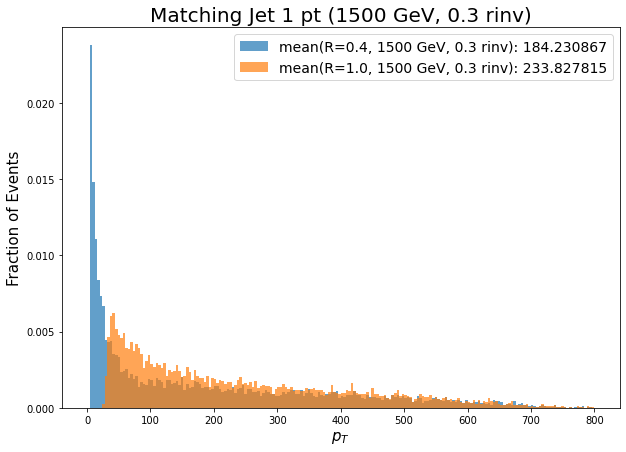

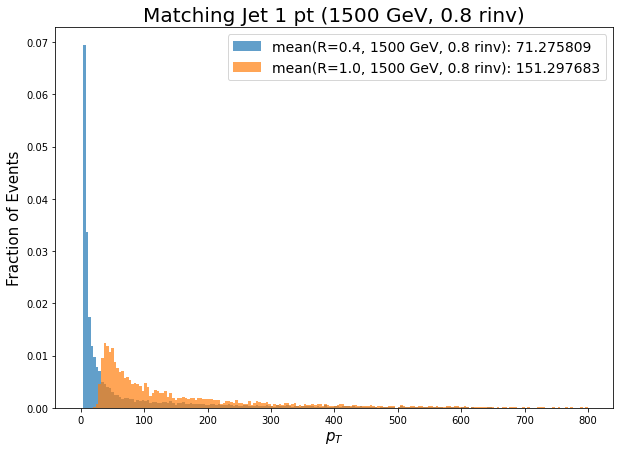

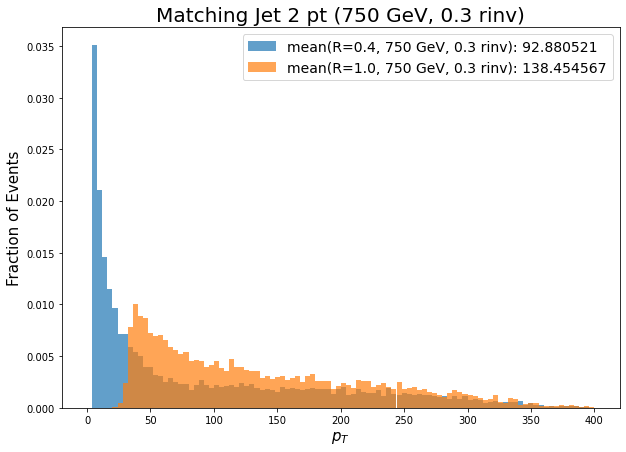

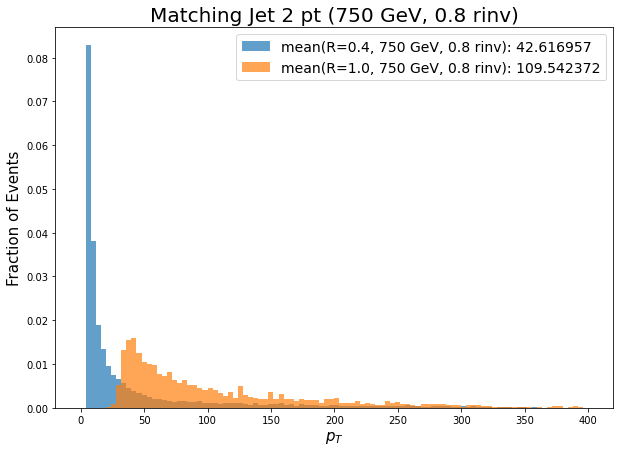

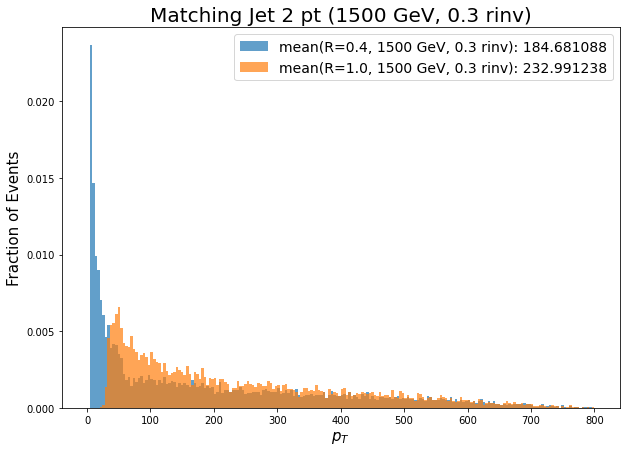

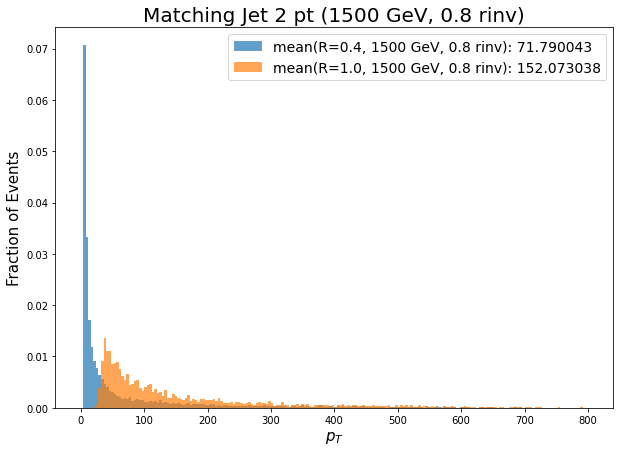

In [68]:
# Matching Jet 1 pt (750 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
bins=np.linspace(0, 400, 101)
plt.hist(FastJet1_pt_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet1_pt_750_3))
plt.hist(FatJet1_pt_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet1_pt_750_3))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 1 pt (750 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 1 pt (750 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet1_pt_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %ak.mean(FastJet1_pt_750_8))
plt.hist(FatJet1_pt_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %ak.mean(FatJet1_pt_750_8))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 1 pt (750 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 1 pt (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
bins=np.linspace(0, 800, 201)
plt.hist(FastJet1_pt_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet1_pt_1500_3))
plt.hist(FatJet1_pt_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet1_pt_1500_3))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 1 pt (1500 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 1 pt (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet1_pt_1500_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet1_pt_1500_8))
plt.hist(FatJet1_pt_1500_8, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet1_pt_1500_8))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 1 pt (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 2 pt (750 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
bins=np.linspace(0, 400, 101)
plt.hist(FastJet2_pt_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet2_pt_750_3))
plt.hist(FatJet2_pt_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet2_pt_750_3))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 2 pt (750 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 2 pt (750 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet2_pt_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %ak.mean(FastJet2_pt_750_8))
plt.hist(FatJet2_pt_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %ak.mean(FatJet2_pt_750_8))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 2 pt (750 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 2 pt (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
bins=np.linspace(0, 800, 201)
plt.hist(FastJet2_pt_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet2_pt_1500_3))
plt.hist(FatJet2_pt_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet2_pt_1500_3))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 2 pt (1500 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 2 pt (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet2_pt_1500_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet2_pt_1500_8))
plt.hist(FatJet2_pt_1500_8, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet2_pt_1500_8))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 2 pt (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

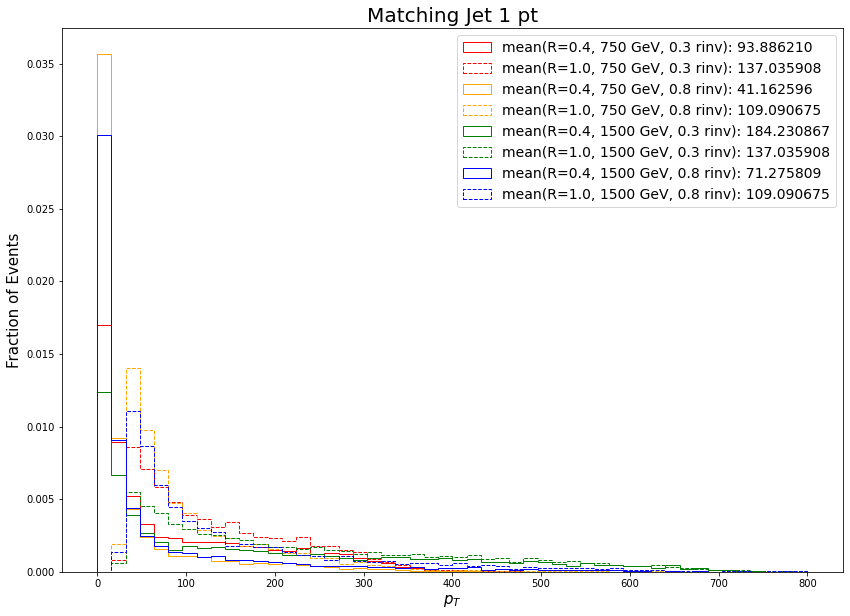

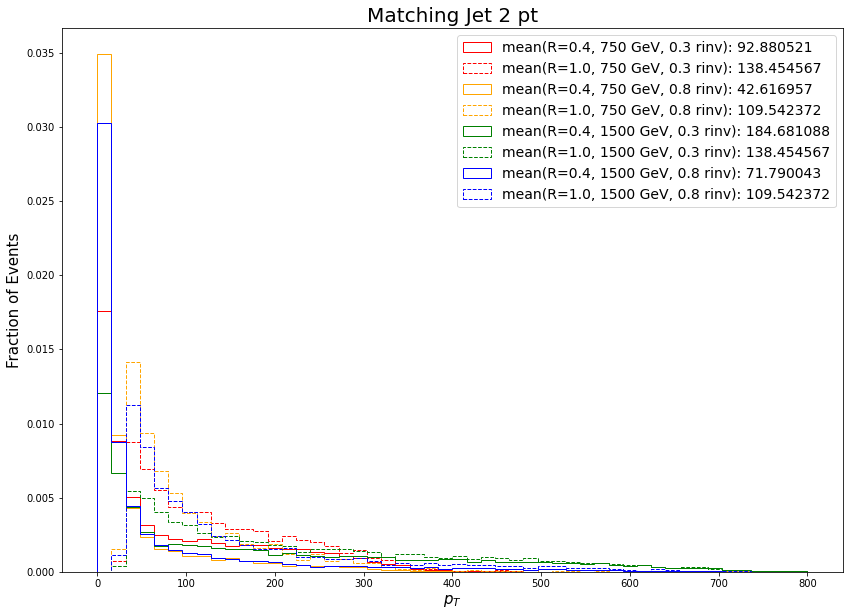

In [69]:
# Matching Jet 1 pt (combining four plots)
plt.figure(figsize=(14,10)) 
bins=np.linspace(0, 800, 51)
plt.hist(FastJet1_pt_750_3, bins=bins, color='red', histtype='step', density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet1_pt_750_3))
plt.hist(FatJet1_pt_750_3, bins=bins, color='red', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet1_pt_750_3))

plt.hist(FastJet1_pt_750_8, bins=bins, color='orange', histtype='step', density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %ak.mean(FastJet1_pt_750_8))
plt.hist(FatJet1_pt_750_8, bins=bins, color='orange', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %ak.mean(FatJet1_pt_750_8))

plt.hist(FastJet1_pt_1500_3, bins=bins, color='green', histtype='step', density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet1_pt_1500_3))
plt.hist(FatJet1_pt_1500_3, bins=bins, color='green', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet1_pt_750_3))

plt.hist(FastJet1_pt_1500_8, bins=bins, color='blue', histtype='step', density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet1_pt_1500_8))
plt.hist(FatJet1_pt_1500_8, bins=bins, color='blue', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet1_pt_750_8))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 1 pt', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 2 pt (combining four plots)
plt.figure(figsize=(14,10)) 
bins=np.linspace(0, 800, 51)
plt.hist(FastJet2_pt_750_3, bins=bins, color='red', histtype='step', density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet2_pt_750_3))
plt.hist(FatJet2_pt_750_3, bins=bins, color='red', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet2_pt_750_3))

plt.hist(FastJet2_pt_750_8, bins=bins, color='orange', histtype='step', density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %ak.mean(FastJet2_pt_750_8))
plt.hist(FatJet2_pt_750_8, bins=bins, color='orange', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %ak.mean(FatJet2_pt_750_8))

plt.hist(FastJet2_pt_1500_3, bins=bins, color='green', histtype='step', density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet2_pt_1500_3))
plt.hist(FatJet2_pt_1500_3, bins=bins, color='green', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet2_pt_750_3))

plt.hist(FastJet2_pt_1500_8, bins=bins, color='blue', histtype='step', density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet2_pt_1500_8))
plt.hist(FatJet2_pt_1500_8, bins=bins, color='blue', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet2_pt_750_8))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 2 pt', fontsize=20)
plt.legend(fontsize=14)
plt.show()

## Matching Jets Eta

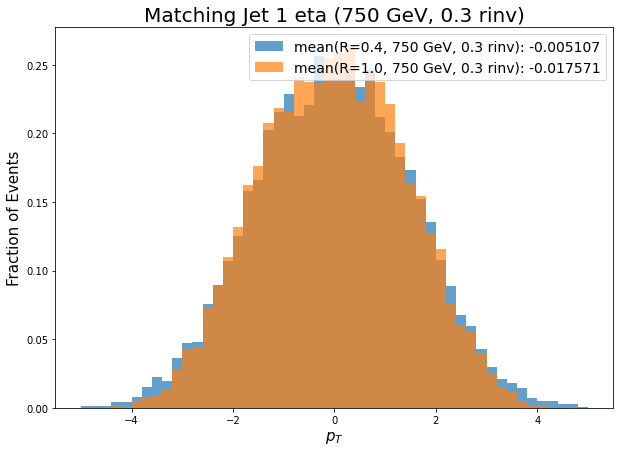

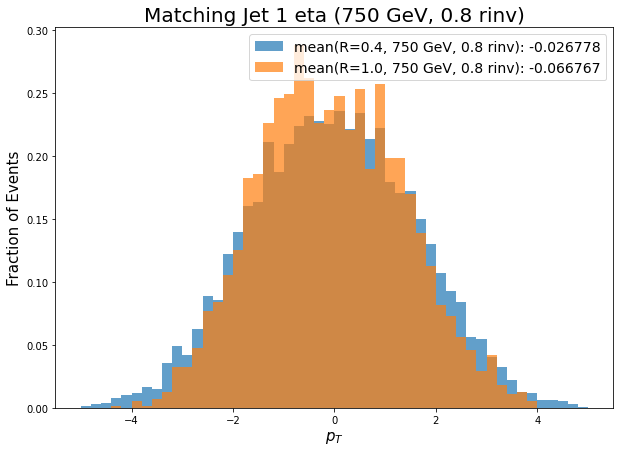

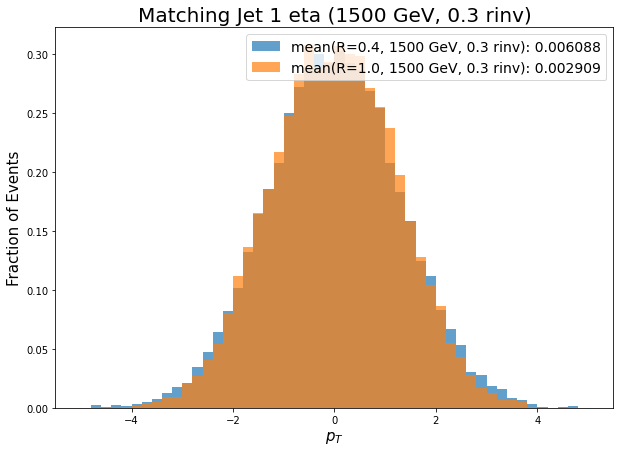

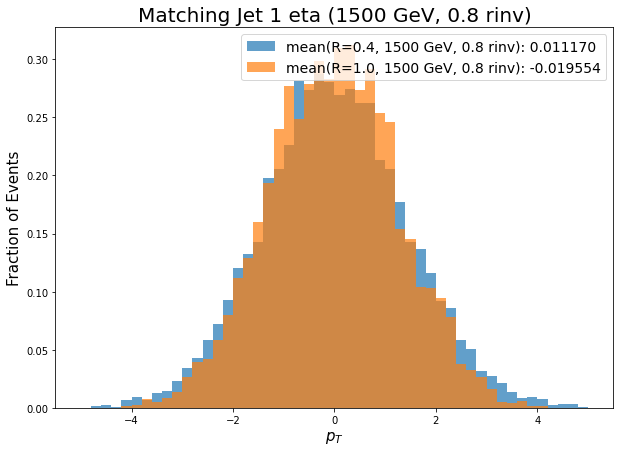

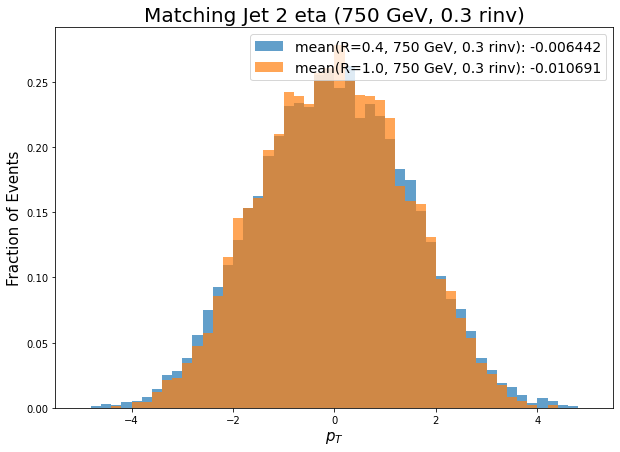

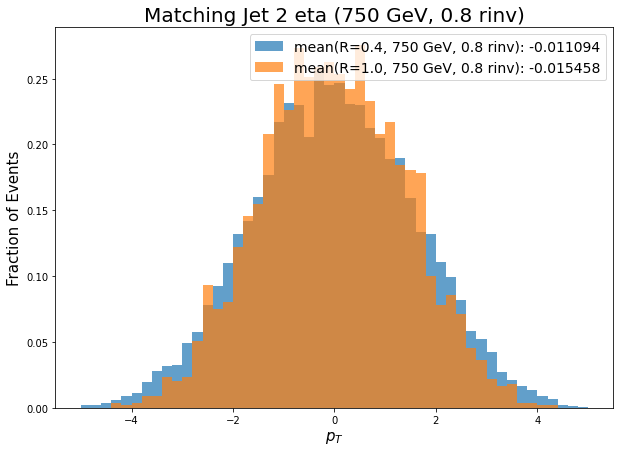

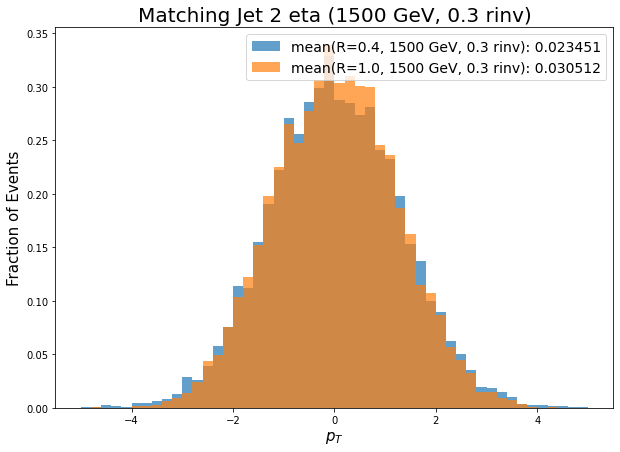

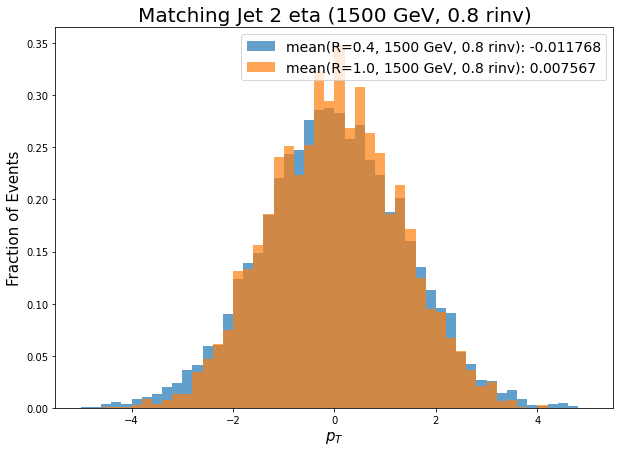

In [85]:
# Matching Jet 1 eta (750 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
bins=np.linspace(-5, 5, 51)
plt.hist(FastJet1_eta_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet1_eta_750_3))
plt.hist(FatJet1_eta_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet1_eta_750_3))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 1 eta (750 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 1 eta (750 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet1_eta_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %ak.mean(FastJet1_eta_750_8))
plt.hist(FatJet1_eta_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %ak.mean(FatJet1_eta_750_8))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 1 eta (750 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 1 eta (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet1_eta_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet1_eta_1500_3))
plt.hist(FatJet1_eta_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet1_eta_1500_3))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 1 eta (1500 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 1 eta (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet1_eta_1500_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet1_eta_1500_8))
plt.hist(FatJet1_eta_1500_8, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet1_eta_1500_8))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 1 eta (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 2 eta (750 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet2_eta_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet2_eta_750_3))
plt.hist(FatJet2_eta_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet2_eta_750_3))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 2 eta (750 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 2 eta (750 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet2_eta_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %ak.mean(FastJet2_eta_750_8))
plt.hist(FatJet2_eta_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %ak.mean(FatJet2_eta_750_8))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 2 eta (750 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 2 eta (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet2_eta_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet2_eta_1500_3))
plt.hist(FatJet2_eta_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet2_eta_1500_3))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 2 eta (1500 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 2 eta (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet2_eta_1500_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet2_eta_1500_8))
plt.hist(FatJet2_eta_1500_8, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet2_eta_1500_8))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 2 eta (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

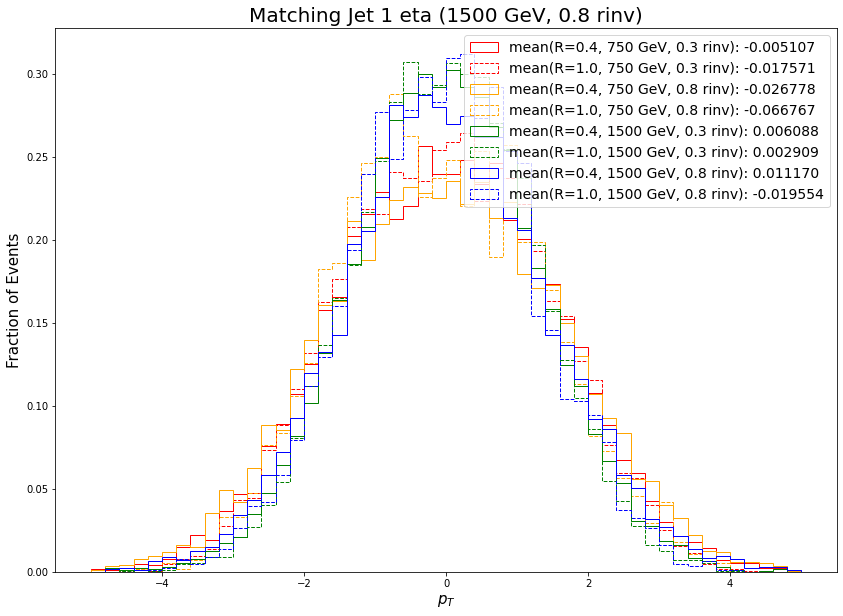

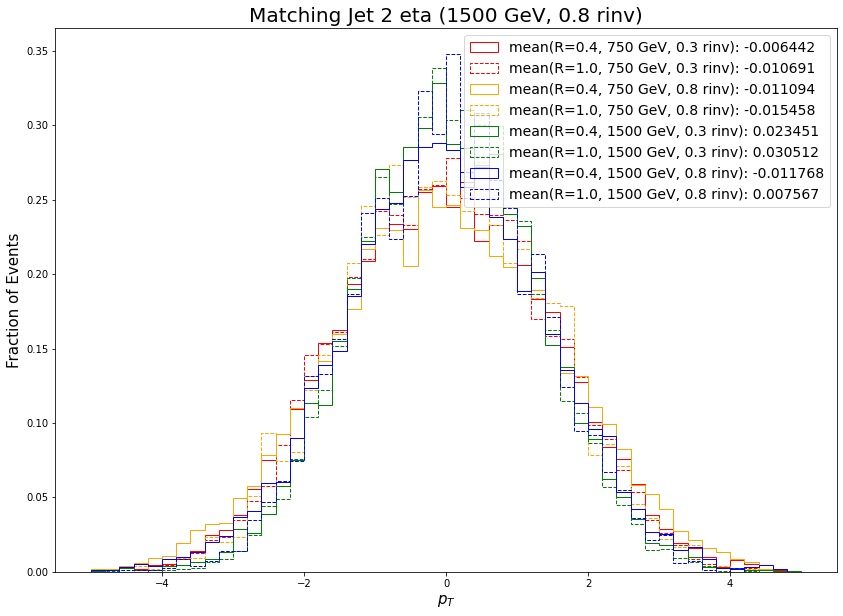

In [86]:
# Matching Jet 1 eta (combining four plots)
plt.figure(figsize=(14,10)) 
bins=np.linspace(-5, 5, 51)
plt.hist(FastJet1_eta_750_3, bins=bins, color='red', histtype='step', density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet1_eta_750_3))
plt.hist(FatJet1_eta_750_3, bins=bins, color='red', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet1_eta_750_3))

plt.hist(FastJet1_eta_750_8, bins=bins, color='orange', histtype='step', density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %ak.mean(FastJet1_eta_750_8))
plt.hist(FatJet1_eta_750_8, bins=bins, color='orange', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %ak.mean(FatJet1_eta_750_8))

plt.hist(FastJet1_eta_1500_3, bins=bins, color='green', histtype='step', density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet1_eta_1500_3))
plt.hist(FatJet1_eta_1500_3, bins=bins, color='green', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet1_eta_1500_3))

plt.hist(FastJet1_eta_1500_8, bins=bins, color='blue', histtype='step', density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet1_eta_1500_8))
plt.hist(FatJet1_eta_1500_8, bins=bins, color='blue', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet1_eta_1500_8))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 1 eta (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 2 eta (combining four plots)
plt.figure(figsize=(14,10)) 
plt.hist(FastJet2_eta_750_3, bins=bins, color='red', histtype='step', density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet2_eta_750_3))
plt.hist(FatJet2_eta_750_3, bins=bins, color='red', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet2_eta_750_3))

plt.hist(FastJet2_eta_750_8, bins=bins, color='orange', histtype='step', density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %ak.mean(FastJet2_eta_750_8))
plt.hist(FatJet2_eta_750_8, bins=bins, color='orange', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %ak.mean(FatJet2_eta_750_8))

plt.hist(FastJet2_eta_1500_3, bins=bins, color='green', histtype='step', density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet2_eta_1500_3))
plt.hist(FatJet2_eta_1500_3, bins=bins, color='green', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet2_eta_1500_3))

plt.hist(FastJet2_eta_1500_8, bins=bins, color='blue', histtype='step', density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet2_eta_1500_8))
plt.hist(FatJet2_eta_1500_8, bins=bins, color='blue', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet2_eta_1500_8))
plt.xlabel(r'$p_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 2 eta (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

## Matching Jet 12 Delta Eta and Delta Phi

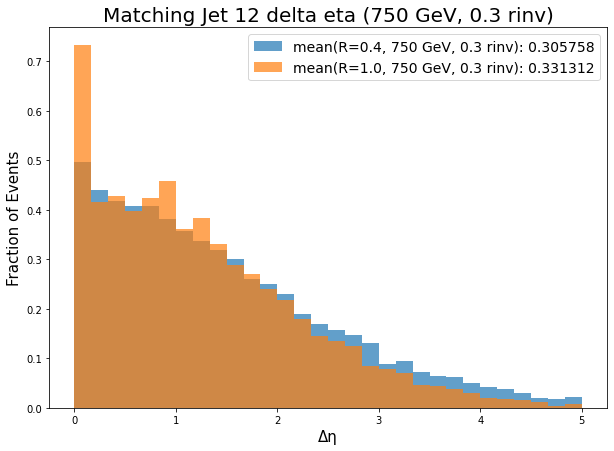

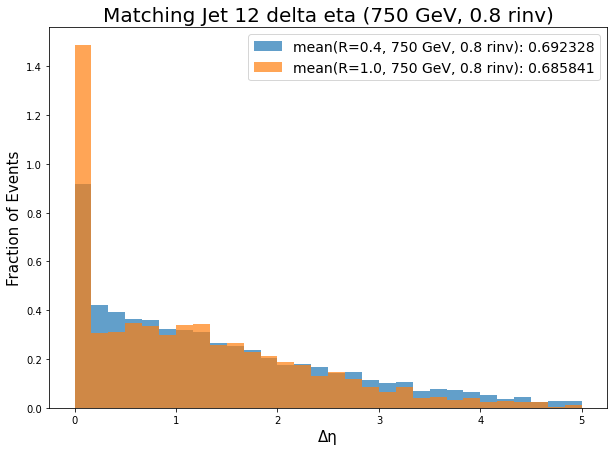

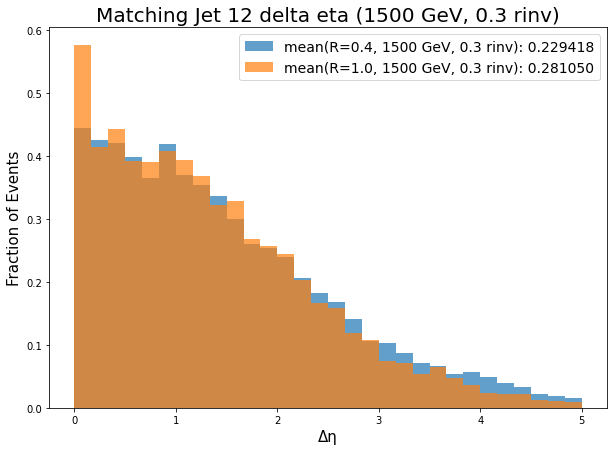

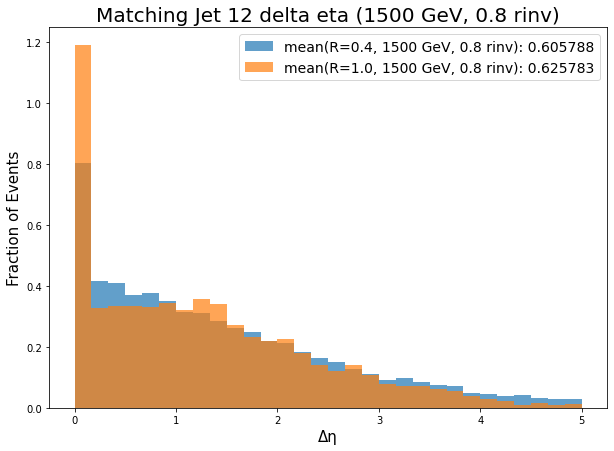

In [87]:
# Matching Jet 12 delta eta (750 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
bins = np.linspace(0, 5, 31)
plt.hist(FastJet12_delta_eta_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet1_delta_eta_750_3))
plt.hist(FatJet12_delta_eta_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet1_delta_eta_750_3))
plt.xlabel(r'Δη', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 12 delta eta (750 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 12 delta eta (750 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet12_delta_eta_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %ak.mean(FastJet1_delta_eta_750_8))
plt.hist(FatJet12_delta_eta_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %ak.mean(FatJet1_delta_eta_750_8))
plt.xlabel(r'Δη', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 12 delta eta (750 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 12 delta eta (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet12_delta_eta_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet1_delta_eta_1500_3))
plt.hist(FatJet12_delta_eta_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet1_delta_eta_1500_3))
plt.xlabel(r'Δη', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 12 delta eta (1500 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 12 delta eta (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet12_delta_eta_1500_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet1_delta_eta_1500_8))
plt.hist(FatJet12_delta_eta_1500_8, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet1_delta_eta_1500_8))
plt.xlabel(r'Δη', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 12 delta eta (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

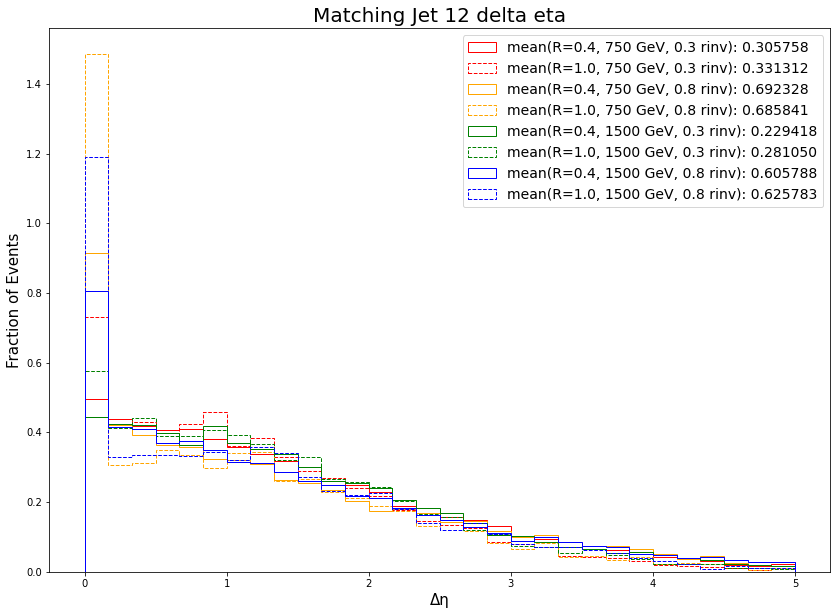

In [89]:
# Matching Jet 12 delta eta (combining four plots)
plt.figure(figsize=(14,10)) 
bins = np.linspace(0, 5, 31)
plt.hist(FastJet12_delta_eta_750_3, bins=bins, histtype='step', color='red', density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet1_delta_eta_750_3))
plt.hist(FatJet12_delta_eta_750_3, bins=bins, histtype='step', linestyle='--', color='red', density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet1_delta_eta_750_3))

plt.hist(FastJet12_delta_eta_750_8, bins=bins, histtype='step', color='orange', density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %ak.mean(FastJet1_delta_eta_750_8))
plt.hist(FatJet12_delta_eta_750_8, bins=bins, histtype='step', linestyle='--', color='orange', density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %ak.mean(FatJet1_delta_eta_750_8))

plt.hist(FastJet12_delta_eta_1500_3, bins=bins, histtype='step', color='green', density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet1_delta_eta_1500_3))
plt.hist(FatJet12_delta_eta_1500_3, bins=bins, histtype='step', linestyle='--', color='green', density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet1_delta_eta_1500_3))

plt.hist(FastJet12_delta_eta_1500_8, bins=bins, histtype='step', color='blue', density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet1_delta_eta_1500_8))
plt.hist(FatJet12_delta_eta_1500_8, bins=bins, histtype='step', linestyle='--', color='blue', density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet1_delta_eta_1500_8))
plt.xlabel(r'Δη', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 12 delta eta', fontsize=20)
plt.legend(fontsize=14)
plt.show()


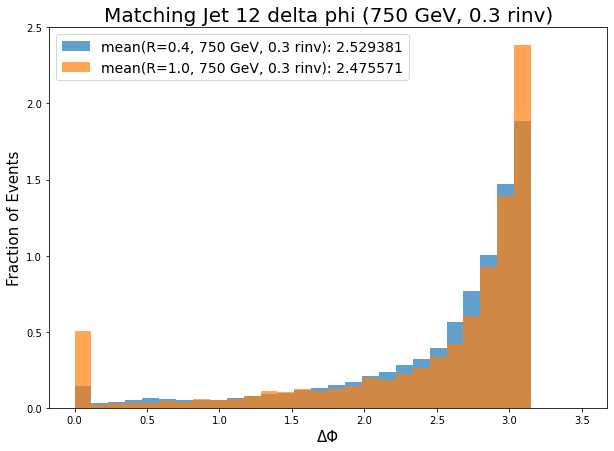

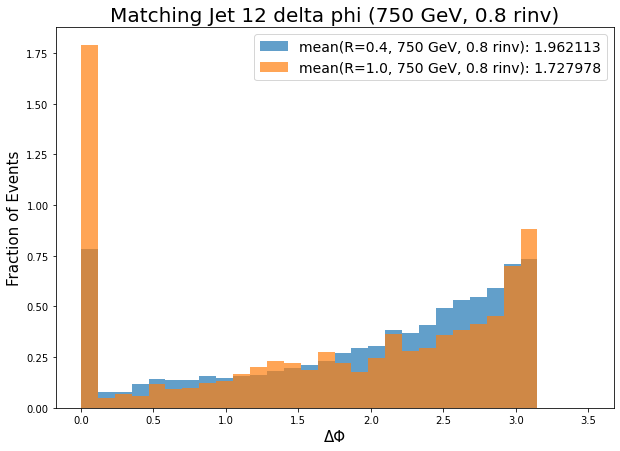

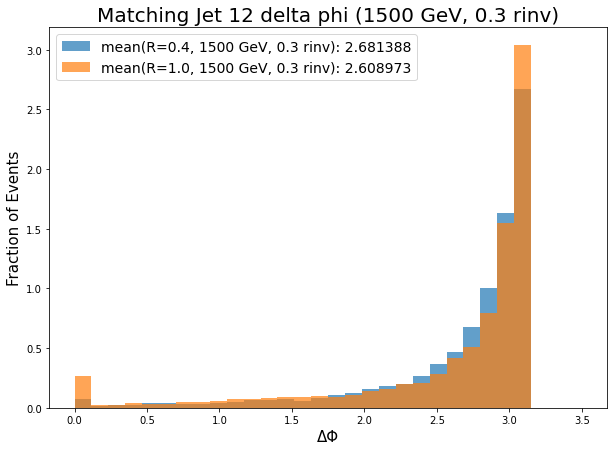

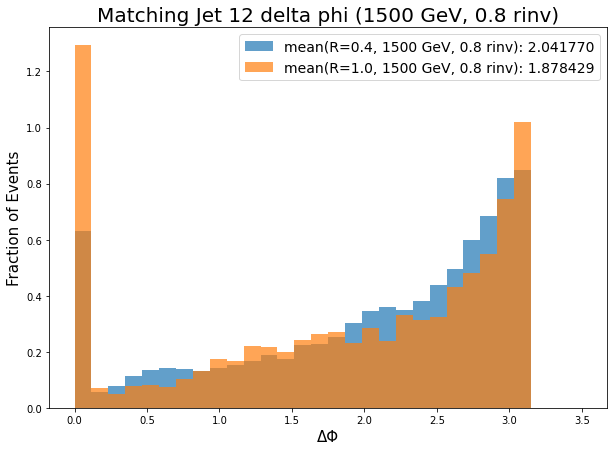

In [81]:
# Matching Jet 1 delta phi (750 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
bins = np.linspace(0, 3.5, 31)
plt.hist(FastJet12_delta_phi_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet12_delta_phi_750_3))
plt.hist(FatJet12_delta_phi_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet12_delta_phi_750_3))
plt.xlabel(r'ΔΦ', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 12 delta phi (750 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 1 delta phi (750 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet12_delta_phi_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %ak.mean(FastJet12_delta_phi_750_8))
plt.hist(FatJet12_delta_phi_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %ak.mean(FatJet12_delta_phi_750_8))
plt.xlabel(r'ΔΦ', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 12 delta phi (750 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 1 delta phi (1500 GeV, 0.3 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet12_delta_phi_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet12_delta_phi_1500_3))
plt.hist(FatJet12_delta_phi_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet12_delta_phi_1500_3))
plt.xlabel(r'ΔΦ', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 12 delta phi (1500 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Matching Jet 1 delta phi (1500 GeV, 0.8 rinv)
plt.figure(figsize=(10,7)) 
plt.hist(FastJet12_delta_phi_1500_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet12_delta_phi_1500_8))
plt.hist(FatJet12_delta_phi_1500_8, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet12_delta_phi_1500_8))
plt.xlabel(r'ΔΦ', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 12 delta phi (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

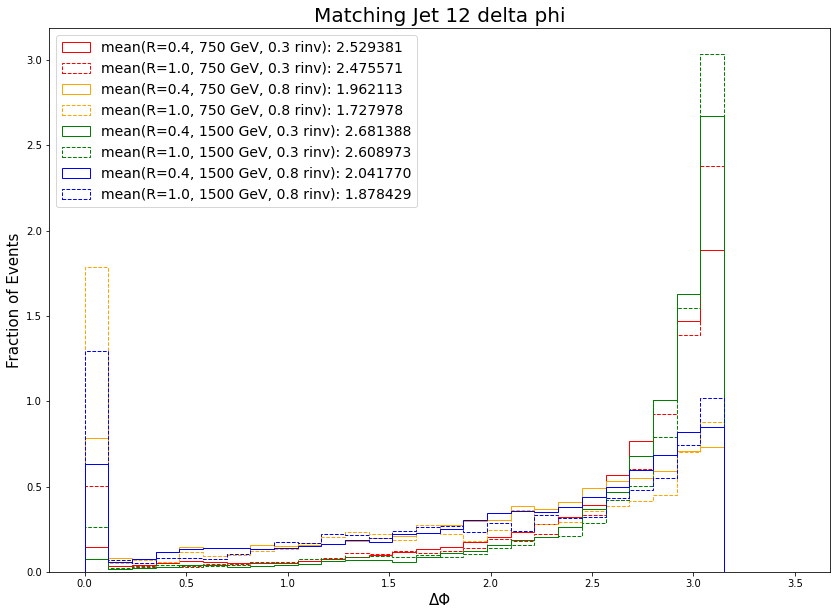

In [84]:
# Matching Jet 1 delta phi (combining four plots)
plt.figure(figsize=(14,10)) 
bins = np.linspace(0, 3.5, 31)
plt.hist(FastJet12_delta_phi_750_3, bins=bins, histtype='step', color='red', density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet12_delta_phi_750_3))
plt.hist(FatJet12_delta_phi_750_3, bins=bins, histtype='step', linestyle='--', color='red', density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet12_delta_phi_750_3))

plt.hist(FastJet12_delta_phi_750_8, bins=bins, histtype='step', color='orange', density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %ak.mean(FastJet12_delta_phi_750_8))
plt.hist(FatJet12_delta_phi_750_8, bins=bins, histtype='step', linestyle='--', color='orange', density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %ak.mean(FatJet12_delta_phi_750_8))

plt.hist(FastJet12_delta_phi_1500_3, bins=bins, histtype='step', color='green', density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet12_delta_phi_1500_3))
plt.hist(FatJet12_delta_phi_1500_3, bins=bins, histtype='step', linestyle='--', color='green', density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet12_delta_phi_1500_3))

plt.hist(FastJet12_delta_phi_1500_8, bins=bins, histtype='step', color='blue', density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet12_delta_phi_1500_8))
plt.hist(FatJet12_delta_phi_1500_8, bins=bins, histtype='step', linestyle='--', color='blue', density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet12_delta_phi_1500_8))
plt.xlabel(r'ΔΦ', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Matching Jet 12 delta phi', fontsize=20)
plt.legend(loc='upper left',fontsize=14)
plt.show()



# MT and Mjj

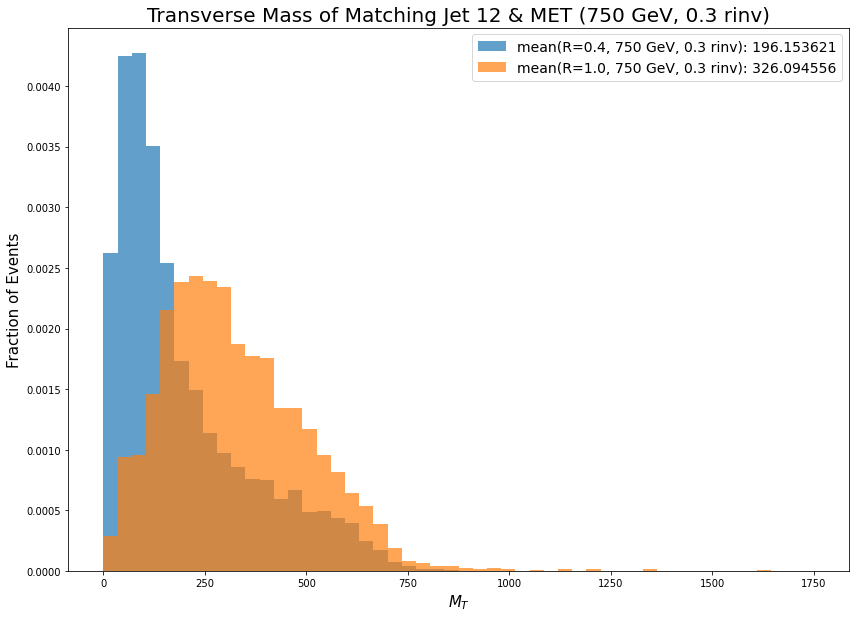

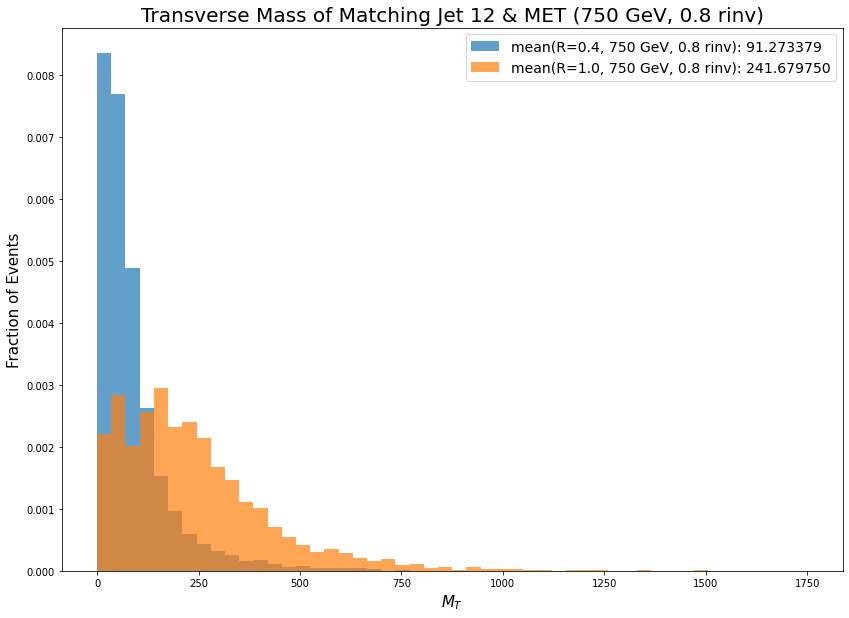

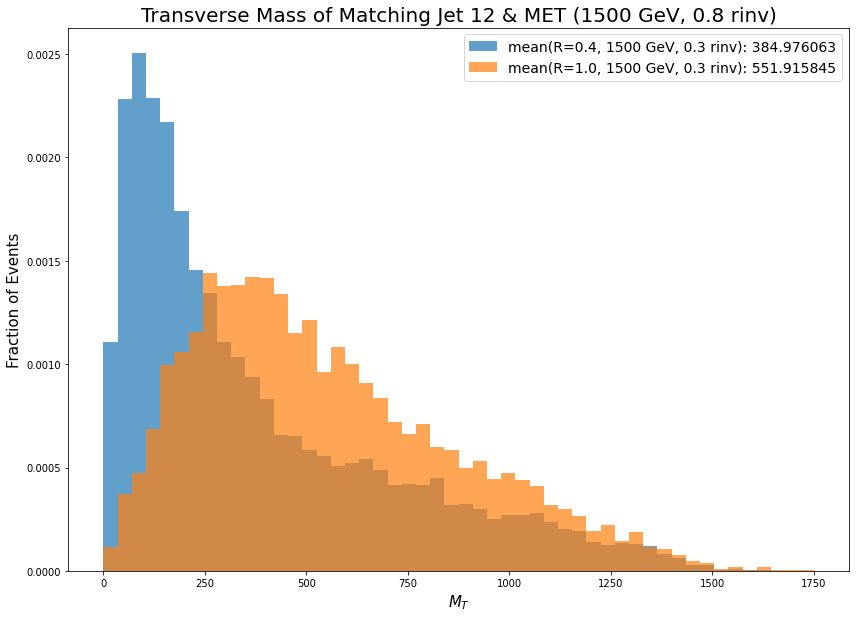

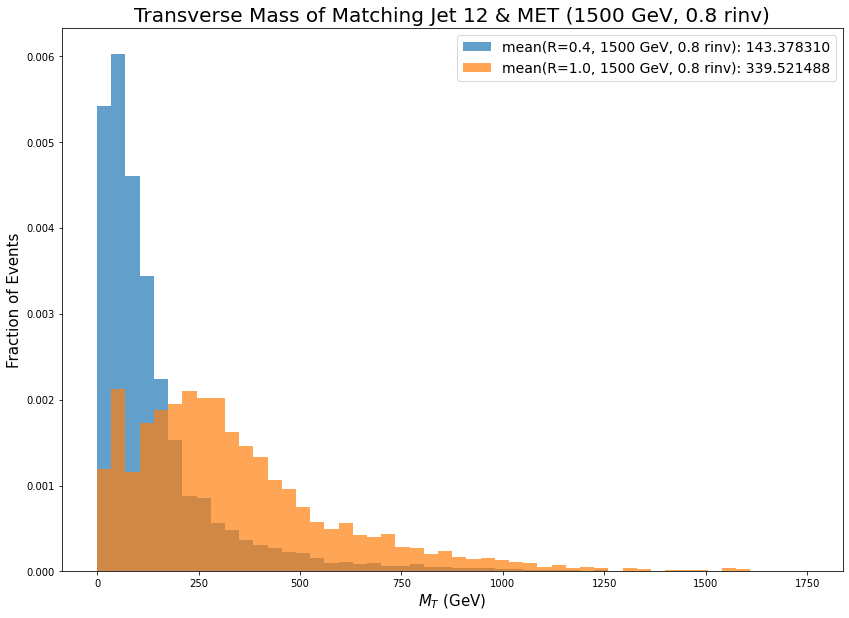

In [57]:
# MT (750 GeV, 0.3 rinv)
plt.figure(figsize=(14,10)) 
bins=np.linspace(0, 1750, 51)
plt.hist(FastJet_MT_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet_MT_750_3))
plt.hist(FatJet_MT_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet_MT_750_3))
plt.xlabel(r'$M_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Transverse Mass of Matching Jet 12 & MET (750 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# MT (750 GeV, 0.8 rinv)
plt.figure(figsize=(14,10)) 
bins=np.linspace(0, 1750, 51)
plt.hist(FastJet_MT_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %np.nanmean(FastJet_MT_750_8))
plt.hist(FatJet_MT_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %np.nanmean(FatJet_MT_750_8))
plt.xlabel(r'$M_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Transverse Mass of Matching Jet 12 & MET (750 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# MT (1500 GeV, 0.3 rinv)
plt.figure(figsize=(14,10)) 
bins=np.linspace(0, 1750, 51)
plt.hist(FastJet_MT_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet_MT_1500_3))
plt.hist(FatJet_MT_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet_MT_1500_3))
plt.xlabel(r'$M_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Transverse Mass of Matching Jet 12 & MET (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# MT (1500 GeV, 0.8 rinv)
plt.figure(figsize=(14,10)) 
bins=np.linspace(0, 1750, 51)
plt.hist(FastJet_MT_1500_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet_MT_1500_8))
plt.hist(FatJet_MT_1500_8, bins=bins, alpha=0.7, linestyle='--', density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet_MT_1500_8))
plt.xlabel(r'$M_{T}$ (GeV)', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Transverse Mass of Matching Jet 12 & MET (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

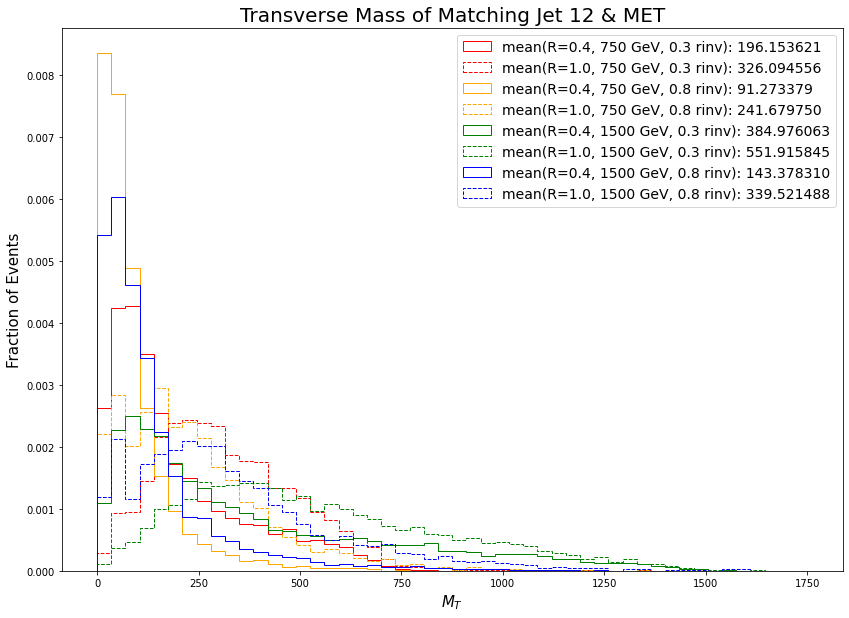

In [53]:
# MT (combining four plots)
plt.figure(figsize=(14,10)) 
bins=np.linspace(0, 1750, 51)
plt.hist(FastJet_MT_750_3, bins=bins, color='red', histtype='step', density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet_MT_750_3))
plt.hist(FatJet_MT_750_3, bins=bins, color='red', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet_MT_750_3))

plt.hist(FastJet_MT_750_8, bins=bins, color='orange', histtype='step', density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %np.nanmean(FastJet_MT_750_8))
plt.hist(FatJet_MT_750_8, bins=bins, color='orange', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %np.nanmean(FatJet_MT_750_8))

plt.hist(FastJet_MT_1500_3, bins=bins, color='green', histtype='step', density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet_MT_1500_3))
plt.hist(FatJet_MT_1500_3, bins=bins, color='green', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet_MT_1500_3))

plt.hist(FastJet_MT_1500_8, bins=bins, color='blue', histtype='step', density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet_MT_1500_8))
plt.hist(FatJet_MT_1500_8, bins=bins, color='blue', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet_MT_1500_8))
plt.xlabel(r'$M_{T}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Transverse Mass of Matching Jet 12 & MET', fontsize=20)
plt.legend(fontsize=14)
plt.show()

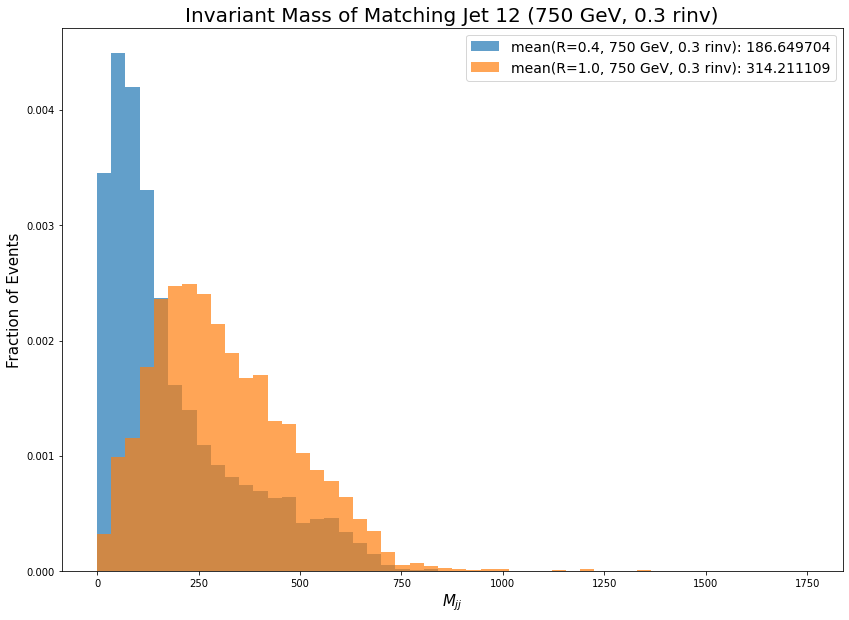

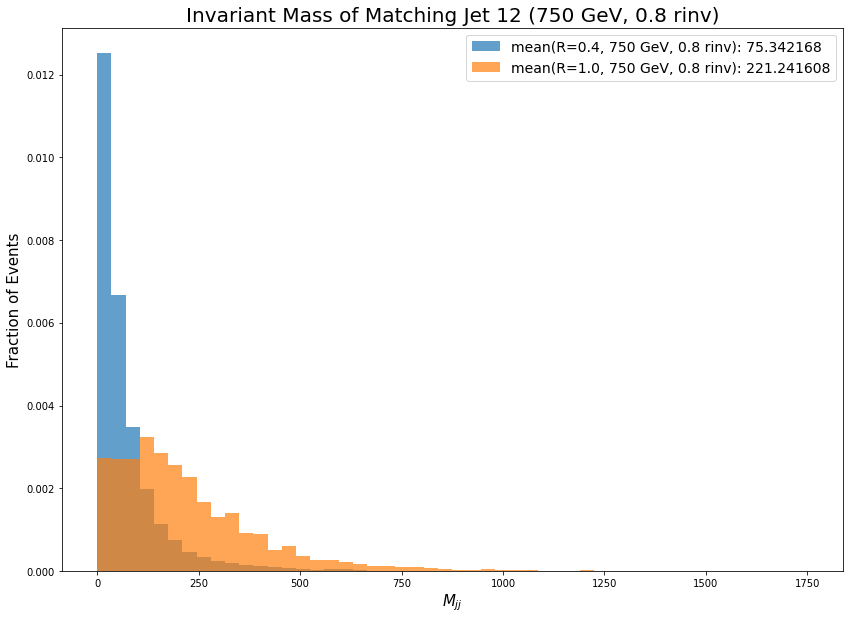

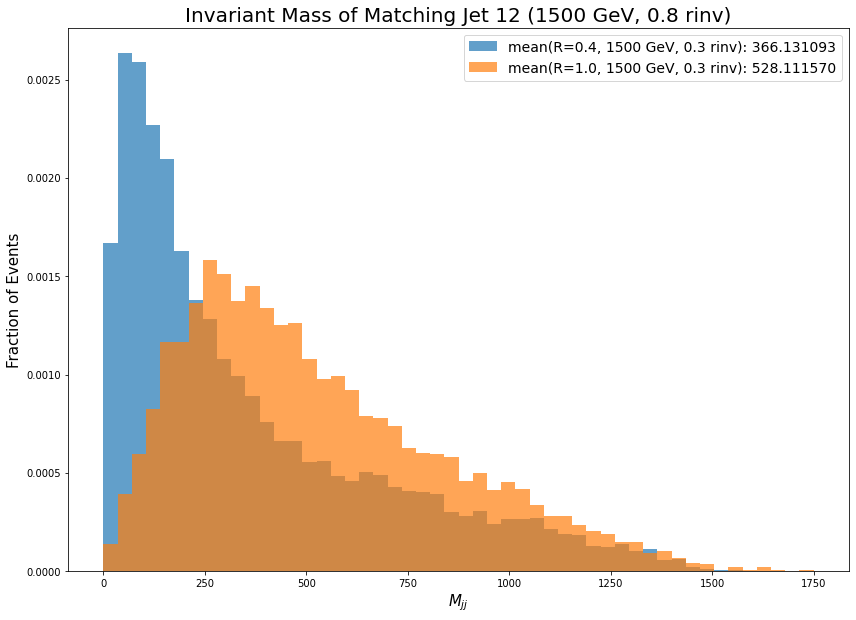

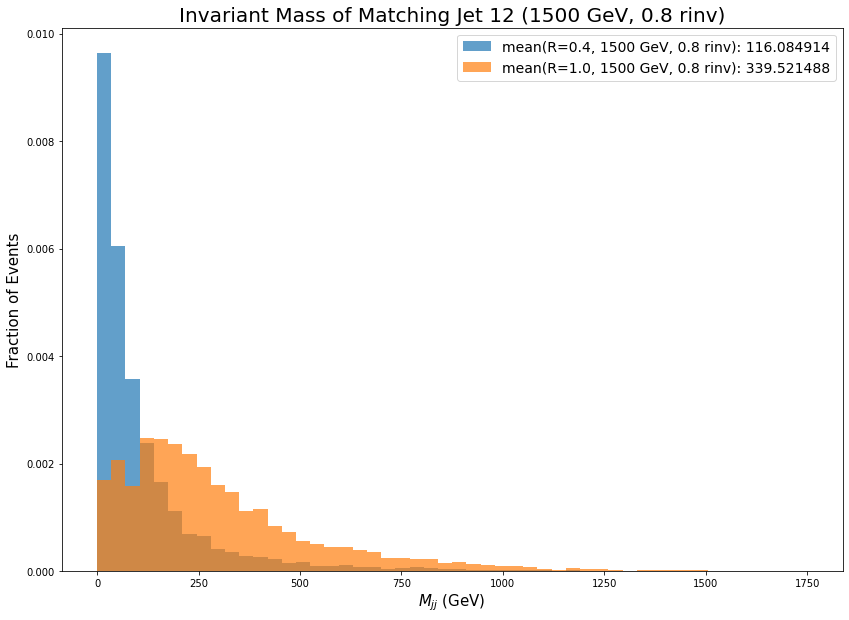

In [58]:
# Mjj (750 GeV, 0.3 rinv)
plt.figure(figsize=(14,10)) 
bins=np.linspace(0, 1750, 51)
plt.hist(FastJet_Mjj_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet_Mjj_750_3))
plt.hist(FatJet_Mjj_750_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet_Mjj_750_3))
plt.xlabel(r'$M_{jj}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Invariant Mass of Matching Jet 12 (750 GeV, 0.3 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# Mjj (750 GeV, 0.8 rinv)
plt.figure(figsize=(14,10)) 
bins=np.linspace(0, 1750, 51)
plt.hist(FastJet_Mjj_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %np.nanmean(FastJet_Mjj_750_8))
plt.hist(FatJet_Mjj_750_8, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %np.nanmean(FatJet_Mjj_750_8))
plt.xlabel(r'$M_{jj}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Invariant Mass of Matching Jet 12 (750 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# MT (1500 GeV, 0.3 rinv)
plt.figure(figsize=(14,10)) 
bins=np.linspace(0, 1750, 51)
plt.hist(FastJet_Mjj_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet_Mjj_1500_3))
plt.hist(FatJet_Mjj_1500_3, bins=bins, alpha=0.7, density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet_Mjj_1500_3))
plt.xlabel(r'$M_{jj}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Invariant Mass of Matching Jet 12 (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

# MT (1500 GeV, 0.8 rinv)
plt.figure(figsize=(14,10)) 
bins=np.linspace(0, 1750, 51)
plt.hist(FastJet_Mjj_1500_8, bins=bins, alpha=0.7, density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet_Mjj_1500_8))
plt.hist(FatJet_Mjj_1500_8, bins=bins, alpha=0.7, linestyle='--', density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet_MT_1500_8))
plt.xlabel(r'$M_{jj}$ (GeV)', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Invariant Mass of Matching Jet 12 (1500 GeV, 0.8 rinv)', fontsize=20)
plt.legend(fontsize=14)
plt.show()

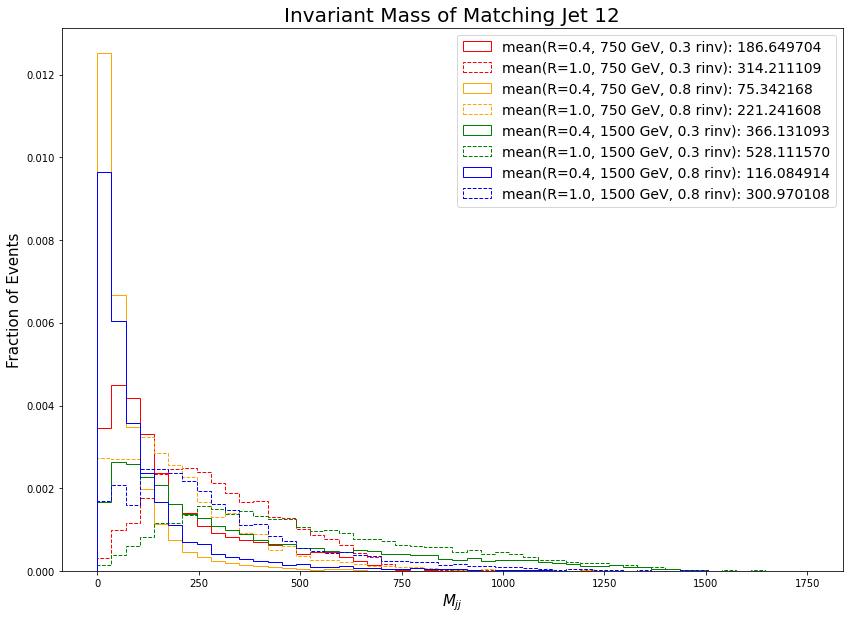

In [55]:
# Mjj (combining four plots)
plt.figure(figsize=(14,10)) 
bins=np.linspace(0, 1750, 51)
plt.hist(FastJet_Mjj_750_3, bins=bins, color='red', histtype='step', density=True, label='mean(R=0.4, 750 GeV, 0.3 rinv): %f' %ak.mean(FastJet_Mjj_750_3))
plt.hist(FatJet_Mjj_750_3, bins=bins, color='red', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 750 GeV, 0.3 rinv): %f' %ak.mean(FatJet_Mjj_750_3))

plt.hist(FastJet_Mjj_750_8, bins=bins, color='orange', histtype='step', density=True, label='mean(R=0.4, 750 GeV, 0.8 rinv): %f' %np.nanmean(FastJet_Mjj_750_8))
plt.hist(FatJet_Mjj_750_8, bins=bins, color='orange', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 750 GeV, 0.8 rinv): %f' %np.nanmean(FatJet_Mjj_750_8))

plt.hist(FastJet_Mjj_1500_3, bins=bins, color='green', histtype='step', density=True, label='mean(R=0.4, 1500 GeV, 0.3 rinv): %f' %ak.mean(FastJet_Mjj_1500_3))
plt.hist(FatJet_Mjj_1500_3, bins=bins, color='green', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 1500 GeV, 0.3 rinv): %f' %ak.mean(FatJet_Mjj_1500_3))

plt.hist(FastJet_Mjj_1500_8, bins=bins, color='blue', histtype='step', density=True, label='mean(R=0.4, 1500 GeV, 0.8 rinv): %f' %ak.mean(FastJet_Mjj_1500_8))
plt.hist(FatJet_Mjj_1500_8, bins=bins, color='blue', histtype='step', linestyle='--', density=True, label='mean(R=1.0, 1500 GeV, 0.8 rinv): %f' %ak.mean(FatJet_Mjj_1500_8))
plt.xlabel(r'$M_{jj}$', fontsize=15)
plt.ylabel('Fraction of Events', fontsize=15)
plt.title('Invariant Mass of Matching Jet 12', fontsize=20)
plt.legend(fontsize=14)
plt.show()